# Ungraded Lab: Using Convolutions with LSTMs

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week4/Labs/C4_W4_Lab_1_LSTM.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

Welcome to the final week of this course! In this lab, you will build upon the RNN models you built last week and append a convolution layer to it. As you saw in previous courses, convolution filters can also capture features from sequences so it's good to try them out when exploring model architectures. Let's begin!

## Imports

In [1]:
import tensorflow as tf
from keras import backend, Sequential, layers, Input, callbacks, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Utilities

You will be plotting the MAE and loss later so the `plot_series()` is extended to have more labelling functionality. The utilities for generating the synthetic data is the same as the previous labs.

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    sns.set_style("whitegrid")

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
        for y_curr in y:
            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)

    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                            np.cos(season_time * 2 * np.pi),
                            1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate the Synthetic Data

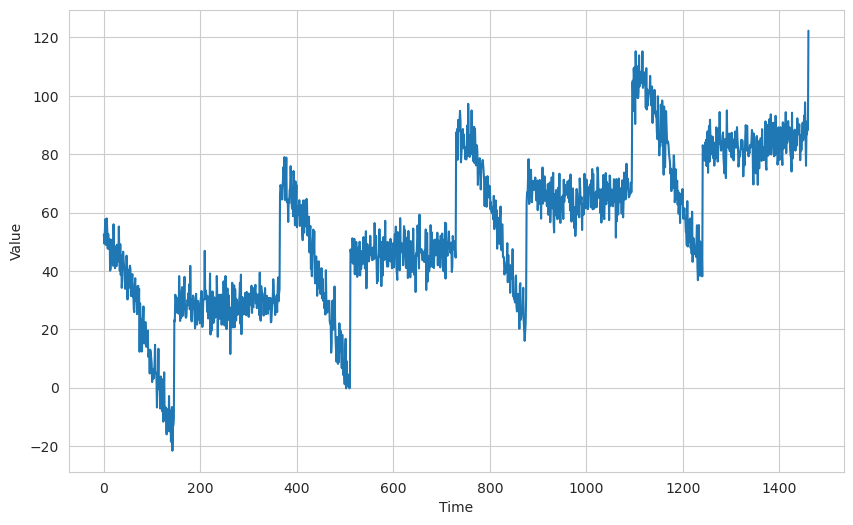

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

As mentioned in the lectures, you can experiment with different batch sizing here and see how it affects your results.

In [5]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-06-14 13:27:19.575001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2189 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


## Build the Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [8]:
# Reset states generated by Keras
backend.clear_session()

# Build the model
model = Sequential([Input(shape=(window_size, 1)),
                    layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(64),
                    layers.Dense(1),
                    layers.Lambda(lambda x: x * 400)])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so you can reset it later.

In [9]:
# Get initial weights
init_weights = model.get_weights()

After that, you can tune the model as usual.

In [10]:
# Set the learning rate scheduler
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-06-14 13:27:20.959796: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10.1191 - learning_rate: 1.0000e-08
Epoch 2/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7715

2024-06-14 13:27:22.321457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:22.321619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7513 - learning_rate: 1.1220e-08
Epoch 3/100
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8797 

2024-06-14 13:27:22.548364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:22.548387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5423 - learning_rate: 1.2589e-08
Epoch 4/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1886

2024-06-14 13:27:22.809298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:22.809323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0803 - learning_rate: 1.4125e-08
Epoch 5/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8681 

2024-06-14 13:27:23.038534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:23.038561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0858 - learning_rate: 1.5849e-08
Epoch 6/100
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7040 

2024-06-14 13:27:23.332996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:23.333022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0452 - learning_rate: 1.7783e-08
Epoch 7/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9263

2024-06-14 13:27:23.602004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:23.602024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6230 - learning_rate: 1.9953e-08
Epoch 8/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6898

2024-06-14 13:27:23.864662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:23.864688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7659 - learning_rate: 2.2387e-08
Epoch 9/100
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3026 

2024-06-14 13:27:24.091776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:24.091803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0470 - learning_rate: 2.5119e-08
Epoch 10/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6750

2024-06-14 13:27:24.422814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:24.422866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5786 - learning_rate: 2.8184e-08
Epoch 11/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9297

2024-06-14 13:27:24.703084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:24.703109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9796 - learning_rate: 3.1623e-08
Epoch 12/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2991

2024-06-14 13:27:25.033737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:25.033777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1506 - learning_rate: 3.5481e-08
Epoch 13/100
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8349

2024-06-14 13:27:25.277847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:25.277869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8481 - learning_rate: 3.9811e-08
Epoch 14/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6849

2024-06-14 13:27:25.564574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:25.564597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6248 - learning_rate: 4.4668e-08
Epoch 15/100
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7043

2024-06-14 13:27:25.796109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:25.796130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9932 - learning_rate: 5.0119e-08
Epoch 16/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2464

2024-06-14 13:27:26.060410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:26.060436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1935 - learning_rate: 5.6234e-08
Epoch 17/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1271

2024-06-14 13:27:26.283084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:26.283105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0915 - learning_rate: 6.3096e-08
Epoch 18/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2914

2024-06-14 13:27:26.529278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:26.529302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5250 - learning_rate: 7.0795e-08
Epoch 19/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2414

2024-06-14 13:27:26.772127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:26.772155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0834 - learning_rate: 7.9433e-08
Epoch 20/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4081

2024-06-14 13:27:27.005862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:27.005900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5294 - learning_rate: 8.9125e-08
Epoch 21/100
40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6656

2024-06-14 13:27:27.239791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:27.239823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7352 - learning_rate: 1.0000e-07
Epoch 22/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0814

2024-06-14 13:27:27.453236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:27.453262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8289 - learning_rate: 1.1220e-07
Epoch 23/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9646

2024-06-14 13:27:27.694737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:27.694766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1669 - learning_rate: 1.2589e-07
Epoch 24/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2550

2024-06-14 13:27:27.919448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:27.919471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3146 - learning_rate: 1.4125e-07
Epoch 25/100
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2025

2024-06-14 13:27:28.156136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:28.156173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2030 - learning_rate: 1.5849e-07
Epoch 26/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4595

2024-06-14 13:27:28.457004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:28.457038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3405 - learning_rate: 1.7783e-07
Epoch 27/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8262

2024-06-14 13:27:28.695306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:28.695329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0909 - learning_rate: 1.9953e-07
Epoch 28/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8194

2024-06-14 13:27:29.007510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:29.007553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:29.007576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15098270556278254235
2024-06-14 13:27:29.007586: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:29.007596: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3627238028612259790


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0088 - learning_rate: 2.2387e-07
Epoch 29/100
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3304

2024-06-14 13:27:29.256857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:29.256903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2900 - learning_rate: 2.5119e-07
Epoch 30/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4282

2024-06-14 13:27:29.506561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:29.506588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3223 - learning_rate: 2.8184e-07
Epoch 31/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9562

2024-06-14 13:27:29.788851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:29.788884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1289 - learning_rate: 3.1623e-07
Epoch 32/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9730

2024-06-14 13:27:30.009988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:30.010011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0306 - learning_rate: 3.5481e-07
Epoch 33/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1392

2024-06-14 13:27:30.230501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:30.230523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3058 - learning_rate: 3.9811e-07
Epoch 34/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3665

2024-06-14 13:27:30.476736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:30.476764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3457 - learning_rate: 4.4668e-07
Epoch 35/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9474

2024-06-14 13:27:30.713283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:30.713305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0049 - learning_rate: 5.0119e-07
Epoch 36/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5211

2024-06-14 13:27:30.930091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:30.930114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5227 - learning_rate: 5.6234e-07
Epoch 37/100
40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9581

2024-06-14 13:27:31.172026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:31.172057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0694 - learning_rate: 6.3096e-07
Epoch 38/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1641

2024-06-14 13:27:31.388583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:31.388611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0508 - learning_rate: 7.0795e-07
Epoch 39/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9728

2024-06-14 13:27:31.608774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:31.608804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8607 - learning_rate: 7.9433e-07
Epoch 40/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5151

2024-06-14 13:27:31.865810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:31.865836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5677 - learning_rate: 8.9125e-07
Epoch 41/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0347

2024-06-14 13:27:32.125054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:32.125084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9073 - learning_rate: 1.0000e-06
Epoch 42/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3395

2024-06-14 13:27:32.373169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:32.373241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6633 - learning_rate: 1.1220e-06
Epoch 43/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3576

2024-06-14 13:27:32.650109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:32.650132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5902 - learning_rate: 1.2589e-06
Epoch 44/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9132

2024-06-14 13:27:32.885976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:32.886001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1829 - learning_rate: 1.4125e-06
Epoch 45/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0253

2024-06-14 13:27:33.122493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:33.122517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1484 - learning_rate: 1.5849e-06
Epoch 46/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4965

2024-06-14 13:27:33.342091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:33.342123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6109 - learning_rate: 1.7783e-06
Epoch 47/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8498

2024-06-14 13:27:33.592787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:33.592814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6379 - learning_rate: 1.9953e-06
Epoch 48/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8206

2024-06-14 13:27:33.832358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:33.832383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6023 - learning_rate: 2.2387e-06
Epoch 49/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8258

2024-06-14 13:27:34.066284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:27:34.066368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1244 - learning_rate: 2.5119e-06
Epoch 50/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6074

2024-06-14 13:27:34.288853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:34.288878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5087 - learning_rate: 2.8184e-06
Epoch 51/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7304

2024-06-14 13:27:34.569938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:34.569961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3943 - learning_rate: 3.1623e-06
Epoch 52/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4081

2024-06-14 13:27:34.799973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:34.799997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3386 - learning_rate: 3.5481e-06
Epoch 53/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3405

2024-06-14 13:27:35.031105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:35.031130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9809 - learning_rate: 3.9811e-06
Epoch 54/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.5269

2024-06-14 13:27:35.257676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:35.257697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.7159 - learning_rate: 4.4668e-06
Epoch 55/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8614   

2024-06-14 13:27:35.482698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:35.482722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4668 - learning_rate: 5.0119e-06
Epoch 56/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8130

2024-06-14 13:27:35.788784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:35.788810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7639 - learning_rate: 5.6234e-06
Epoch 57/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2190

2024-06-14 13:27:36.014945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:36.014969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8375 - learning_rate: 6.3096e-06
Epoch 58/100
40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0632

2024-06-14 13:27:36.282723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:36.282746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0556 - learning_rate: 7.0795e-06
Epoch 59/100
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6006

2024-06-14 13:27:36.501111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:36.501135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.7990 - learning_rate: 7.9433e-06
Epoch 60/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6060

2024-06-14 13:27:36.746040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:36.746064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7264 - learning_rate: 8.9125e-06
Epoch 61/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4703

2024-06-14 13:27:36.964147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:36.964171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6159 - learning_rate: 1.0000e-05
Epoch 62/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.5794

2024-06-14 13:27:37.250446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:37.250484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.3315 - learning_rate: 1.1220e-05
Epoch 63/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4604

2024-06-14 13:27:37.471768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:37.471808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 4363019136719927514
2024-06-14 13:27:37.471815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_12]]
2024-06-14 13:27:37.471835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3627238028612259790
2024-06-14 13:27:37.471848: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15098270556278254235
2024-06-14 13:27:37.471858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2792 - learning_rate: 1.2589e-05
Epoch 64/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0216

2024-06-14 13:27:37.718768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:37.718810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9939 - learning_rate: 1.4125e-05
Epoch 65/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2798 

2024-06-14 13:27:37.963320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:37.963341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7236 - learning_rate: 1.5849e-05
Epoch 66/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1498

2024-06-14 13:27:38.191319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:38.191344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8581 - learning_rate: 1.7783e-05
Epoch 67/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9572

2024-06-14 13:27:38.431149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:38.431170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.5147 - learning_rate: 1.9953e-05
Epoch 68/100
39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.6819

2024-06-14 13:27:38.660333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:38.660358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.4007 - learning_rate: 2.2387e-05
Epoch 69/100
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8884 

2024-06-14 13:27:38.929322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:38.929352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4824 - learning_rate: 2.5119e-05
Epoch 70/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9446 

2024-06-14 13:27:39.304642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:39.304675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9776 - learning_rate: 2.8184e-05
Epoch 71/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4682

2024-06-14 13:27:39.561842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:39.561868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7807 - learning_rate: 3.1623e-05
Epoch 72/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4471

2024-06-14 13:27:39.795765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:39.795787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0248 - learning_rate: 3.5481e-05
Epoch 73/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3700

2024-06-14 13:27:40.019925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:40.019957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4753 - learning_rate: 3.9811e-05
Epoch 74/100
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0185  

2024-06-14 13:27:40.270480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:40.270607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1290 - learning_rate: 4.4668e-05
Epoch 75/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3881

2024-06-14 13:27:40.584281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:40.584304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1537 - learning_rate: 5.0119e-05
Epoch 76/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8129

2024-06-14 13:27:40.810405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:40.810431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0833 - learning_rate: 5.6234e-05
Epoch 77/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8698

2024-06-14 13:27:41.046199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:41.046225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9765 - learning_rate: 6.3096e-05
Epoch 78/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.0689

2024-06-14 13:27:41.277098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:41.277123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1103 - learning_rate: 7.0795e-05
Epoch 79/100
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6582

2024-06-14 13:27:41.541467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:41.541497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8878 - learning_rate: 7.9433e-05
Epoch 80/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6837

2024-06-14 13:27:41.797678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:41.797707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8280 - learning_rate: 8.9125e-05
Epoch 81/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6185 

2024-06-14 13:27:42.036169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:42.036190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9684 - learning_rate: 1.0000e-04
Epoch 82/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6410 

2024-06-14 13:27:42.270252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:42.270278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2775 - learning_rate: 1.1220e-04
Epoch 83/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.0882

2024-06-14 13:27:42.511513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:42.511548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.4100 - learning_rate: 1.2589e-04
Epoch 84/100
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.5023 

2024-06-14 13:27:42.763059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:42.763173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.3330 - learning_rate: 1.4125e-04
Epoch 85/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.9879

2024-06-14 13:27:43.073665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:43.073690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.2049 - learning_rate: 1.5849e-04
Epoch 86/100
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.9850

2024-06-14 13:27:43.314578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:43.314602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8864 - learning_rate: 1.7783e-04
Epoch 87/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.4231

2024-06-14 13:27:43.588982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:43.589010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35.1355 - learning_rate: 1.9953e-04
Epoch 88/100
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.1184 

2024-06-14 13:27:43.844459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:43.844493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.0716 - learning_rate: 2.2387e-04
Epoch 89/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.6238

2024-06-14 13:27:44.138236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:44.138264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.4495 - learning_rate: 2.5119e-04
Epoch 90/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.2276

2024-06-14 13:27:44.368974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:44.369000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.5316 - learning_rate: 2.8184e-04
Epoch 91/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.8574

2024-06-14 13:27:44.618965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:44.618990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.4264 - learning_rate: 3.1623e-04
Epoch 92/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.5764

2024-06-14 13:27:44.868050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:44.868086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.2001 - learning_rate: 3.5481e-04
Epoch 93/100
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.7727

2024-06-14 13:27:45.148277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:45.148318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:45.148332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15098270556278254235
2024-06-14 13:27:45.148339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:45.148368: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3627238028612259790


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.0225 - learning_rate: 3.9811e-04
Epoch 94/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.2136

2024-06-14 13:27:45.380646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:45.380673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.7716 - learning_rate: 4.4668e-04
Epoch 95/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.8942

2024-06-14 13:27:45.627747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:45.627779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.7899 - learning_rate: 5.0119e-04
Epoch 96/100
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36.2458

2024-06-14 13:27:45.875160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:45.875191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.4007 - learning_rate: 5.6234e-04
Epoch 97/100
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.7679

2024-06-14 13:27:46.112006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:46.112032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.4733 - learning_rate: 6.3096e-04
Epoch 98/100
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.5653

2024-06-14 13:27:46.385110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:46.385133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.2456 - learning_rate: 7.0795e-04
Epoch 99/100
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78.3107

2024-06-14 13:27:46.615463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:46.615558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.9011 - learning_rate: 7.9433e-04
Epoch 100/100
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 149.0903

2024-06-14 13:27:46.855157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:46.855186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 147.8875 - learning_rate: 8.9125e-04


2024-06-14 13:27:47.117712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:47.117736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


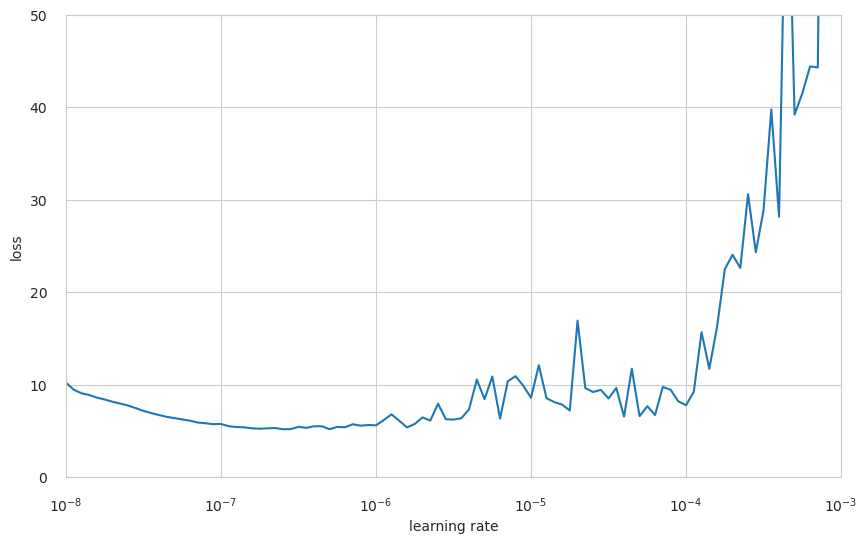

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

plt.xlabel("learning rate")
plt.ylabel("loss")
plt.show()

## Train the Model

To reset the weights, you can simply call the [`set_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights) and pass in the saved weights from earlier.

In [12]:
# Reset states generated by Keras
backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

Then you can set the training parameters and start training.

In [13]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set, epochs=500)

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.0744 - mae: 10.5602
Epoch 2/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0820 - mae: 9.5692  

2024-06-14 13:27:48.965361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:48.965389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7178 - mae: 9.2038
Epoch 3/500
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8972 - mae: 8.3816

2024-06-14 13:27:49.192657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:49.192682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5420 - mae: 8.0258
Epoch 4/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3370 - mae: 7.8164

2024-06-14 13:27:49.415656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:49.415679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:49.415694: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:49.415703: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0544 - mae: 7.5345
Epoch 5/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2675 - mae: 6.7478

2024-06-14 13:27:49.674849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:49.674889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:49.674912: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:49.674921: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:49.674931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2471 - mae: 6.7282
Epoch 6/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4373 - mae: 5.9148

2024-06-14 13:27:49.916219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:49.916253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:27:49.916269: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:49.916274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:49.916282: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6193 - mae: 6.0970
Epoch 7/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2124 - mae: 6.6936

2024-06-14 13:27:50.151765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:50.151790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:50.151804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0378 - mae: 6.5187
Epoch 8/500
38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0858 - mae: 6.5652

2024-06-14 13:27:50.397798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:50.397823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9739 - mae: 6.4540
Epoch 9/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2929 - mae: 5.7759

2024-06-14 13:27:50.628398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:50.628421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4982 - mae: 5.9797
Epoch 10/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3175 - mae: 6.8035 

2024-06-14 13:27:50.890734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:50.890768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:50.890780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:50.890789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:50.890797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0237 - mae: 6.5065
Epoch 11/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9116 - mae: 6.3950

2024-06-14 13:27:51.142341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:51.142367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:51.142383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:51.142390: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6687 - mae: 6.1521
Epoch 12/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5502 - mae: 6.0259

2024-06-14 13:27:51.452360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:51.452386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:51.452402: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:51.452411: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5362 - mae: 6.0154
Epoch 13/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3037 - mae: 5.7911

2024-06-14 13:27:51.730527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:51.730552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:51.730570: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3834 - mae: 5.8679
Epoch 14/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1267 - mae: 5.6000

2024-06-14 13:27:52.008518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:52.008547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:52.008564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3184 - mae: 5.7943
Epoch 15/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9292 - mae: 5.4062

2024-06-14 13:27:52.271975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:52.272003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:52.272021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:52.272030: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0124 - mae: 5.4896
Epoch 16/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9104 - mae: 6.3954

2024-06-14 13:27:52.558197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:52.558221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:52.558236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:52.558247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6077 - mae: 6.0893
Epoch 17/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0611 - mae: 6.5394

2024-06-14 13:27:52.808396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:52.808422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:52.808438: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7838 - mae: 6.2633
Epoch 18/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2361 - mae: 5.7072

2024-06-14 13:27:53.092519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:53.092547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:27:53.092563: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:53.092569: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:53.092608: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1939 - mae: 5.6685
Epoch 19/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8417 - mae: 5.3218

2024-06-14 13:27:53.398197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:53.398225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9278 - mae: 5.4064
Epoch 20/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4144 - mae: 5.8944

2024-06-14 13:27:53.671290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:53.671315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:53.671331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:53.671339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2214 - mae: 5.6994
Epoch 21/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9946 - mae: 5.4711

2024-06-14 13:27:53.947076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:53.947105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:53.947123: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9347 - mae: 5.4123
Epoch 22/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2203 - mae: 5.7033

2024-06-14 13:27:54.215317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:54.215340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1975 - mae: 5.6778
Epoch 23/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0053 - mae: 5.4860

2024-06-14 13:27:54.458831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:54.458859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:54.458875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0472 - mae: 5.5277
Epoch 24/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1351 - mae: 5.6118

2024-06-14 13:27:54.729429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:54.729457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:54.729475: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:54.729486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0720 - mae: 5.5481
Epoch 25/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7929 - mae: 5.2647

2024-06-14 13:27:54.968635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:54.968661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:54.968675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8948 - mae: 5.3692
Epoch 26/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8639 - mae: 5.3341

2024-06-14 13:27:55.201046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:55.201074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:55.201085: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:55.201092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:55.201100: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9881 - mae: 5.4605
Epoch 27/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4899 - mae: 5.9669

2024-06-14 13:27:55.502606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:55.502648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:55.502664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:55.502672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:55.502702: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2699 - mae: 5.7470
Epoch 28/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4340 - mae: 4.9090

2024-06-14 13:27:55.755344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:55.755383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:27:55.755398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:55.755408: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:55.755415: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6673 - mae: 5.1447
Epoch 29/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2901 - mae: 5.7719

2024-06-14 13:27:56.032252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:56.032282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:56.032299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1556 - mae: 5.6369
Epoch 30/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6347 - mae: 5.1119

2024-06-14 13:27:56.300256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:56.300281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:56.300299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7826 - mae: 5.2603
Epoch 31/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8628 - mae: 5.3350

2024-06-14 13:27:56.547880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:56.547905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9171 - mae: 5.3897
Epoch 32/500
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8136 - mae: 5.2910

2024-06-14 13:27:56.789578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:56.789602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9754 - mae: 5.4503
Epoch 33/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8670 - mae: 5.3483

2024-06-14 13:27:57.078127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:57.078150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:57.078165: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9193 - mae: 5.3982
Epoch 34/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5172 - mae: 4.9958

2024-06-14 13:27:57.321332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:57.321363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:57.321381: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6423 - mae: 5.1202
Epoch 35/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9657 - mae: 5.4414

2024-06-14 13:27:57.572504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:57.572531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:57.572546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9953 - mae: 5.4719
Epoch 36/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8133 - mae: 5.2821

2024-06-14 13:27:57.826957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:57.826981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9003 - mae: 5.3723
Epoch 37/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2736 - mae: 4.7483

2024-06-14 13:27:58.084174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:58.084201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4931 - mae: 4.9677
Epoch 38/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8648 - mae: 5.3446

2024-06-14 13:27:58.353601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:58.353629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:27:58.353645: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:58.353656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8825 - mae: 5.3616
Epoch 39/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8978 - mae: 5.3789

2024-06-14 13:27:58.618345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:58.618373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:58.618387: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9269 - mae: 5.4070
Epoch 40/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2388 - mae: 5.7142

2024-06-14 13:27:58.868601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:58.868632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:58.868650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1377 - mae: 5.6131
Epoch 41/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1541 - mae: 5.6302

2024-06-14 13:27:59.111838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:27:59.111863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0315 - mae: 5.5066
Epoch 42/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4990 - mae: 4.9775

2024-06-14 13:27:59.391188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:59.391212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:27:59.391221: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:59.391226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:27:59.391232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6604 - mae: 5.1383
Epoch 43/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8535 - mae: 5.3309

2024-06-14 13:27:59.644300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:59.644327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8934 - mae: 5.3699
Epoch 44/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6409 - mae: 5.1110

2024-06-14 13:27:59.896106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:27:59.896128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:27:59.896143: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:27:59.896150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:27:59.896158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7709 - mae: 5.2427
Epoch 45/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2593 - mae: 5.7458

2024-06-14 13:28:00.147652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:00.147677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:00.147692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:00.147700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:00.147707: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1577 - mae: 5.6429
Epoch 46/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6117 - mae: 5.0890

2024-06-14 13:28:00.389305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:00.389334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:00.389343: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:00.389348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:00.389354: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6742 - mae: 5.1514
Epoch 47/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5952 - mae: 5.0618

2024-06-14 13:28:00.634072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:00.634098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:00.634115: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7158 - mae: 5.1881
Epoch 48/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9605 - mae: 5.4400

2024-06-14 13:28:00.890320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:00.890343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8973 - mae: 5.3748
Epoch 49/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1676 - mae: 5.6422

2024-06-14 13:28:01.131595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:01.131620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:01.131629: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:01.131635: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:01.131641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0599 - mae: 5.5350
Epoch 50/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3833 - mae: 5.8591

2024-06-14 13:28:01.378749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:01.378772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9671 - mae: 5.4418
Epoch 51/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2246 - mae: 5.6988

2024-06-14 13:28:01.668685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:01.668723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:01.668739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:01.668850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0860 - mae: 5.5610
Epoch 52/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4018 - mae: 4.8810

2024-06-14 13:28:01.937994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:01.938021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:01.938030: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:01.938035: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:01.938042: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5449 - mae: 5.0245
Epoch 53/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2377 - mae: 5.7067

2024-06-14 13:28:02.192522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:02.192546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:02.192561: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0156 - mae: 5.4877
Epoch 54/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5254 - mae: 4.9981

2024-06-14 13:28:02.462518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:02.462540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:02.462555: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6364 - mae: 5.1110
Epoch 55/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9474 - mae: 5.4335

2024-06-14 13:28:02.707549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:02.707574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8898 - mae: 5.3719
Epoch 56/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0018 - mae: 5.4850

2024-06-14 13:28:02.954610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:02.954636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:02.954644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:02.954649: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:02.954655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8688 - mae: 5.3498
Epoch 57/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1365 - mae: 5.6143

2024-06-14 13:28:03.227812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:03.227838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:03.227848: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:03.227853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:03.227860: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1043 - mae: 5.5825
Epoch 58/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7662 - mae: 5.2468

2024-06-14 13:28:03.476550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:03.476575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7242 - mae: 5.2030
Epoch 59/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8773 - mae: 5.3466

2024-06-14 13:28:03.721256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:03.721282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:03.721291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:03.721296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:03.721302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8462 - mae: 5.3178
Epoch 60/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8431 - mae: 5.3199

2024-06-14 13:28:03.977498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:03.977521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:03.977529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:03.977534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:03.977541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7924 - mae: 5.2691
Epoch 61/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8525 - mae: 5.3289

2024-06-14 13:28:04.223890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:04.223915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:04.223931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:04.223939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:04.223947: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8496 - mae: 5.3264
Epoch 62/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0696 - mae: 4.5471

2024-06-14 13:28:04.462024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:04.462048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3432 - mae: 4.8222
Epoch 63/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5566 - mae: 5.0306

2024-06-14 13:28:04.700629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:04.700654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:04.700672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6165 - mae: 5.0907
Epoch 64/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4944 - mae: 4.9708

2024-06-14 13:28:04.957905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:04.957932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:04.957948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:04.957962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:04.957970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6513 - mae: 5.1278
Epoch 65/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8672 - mae: 5.3433

2024-06-14 13:28:05.231637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:05.231662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7429 - mae: 5.2195
Epoch 66/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1544 - mae: 4.6284

2024-06-14 13:28:05.475409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:05.475431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4164 - mae: 4.8926
Epoch 67/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7190 - mae: 5.1952

2024-06-14 13:28:05.712013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:05.712036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7663 - mae: 5.2430
Epoch 68/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8459 - mae: 5.3214

2024-06-14 13:28:05.945823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:05.945849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8309 - mae: 5.3064
Epoch 69/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5142 - mae: 4.9926

2024-06-14 13:28:06.179640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:06.179665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:06.179678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6229 - mae: 5.1004
Epoch 70/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6161 - mae: 5.0877

2024-06-14 13:28:06.412166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:06.412190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6543 - mae: 5.1270
Epoch 71/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9177 - mae: 5.3935

2024-06-14 13:28:06.646156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:06.646179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7895 - mae: 5.2636
Epoch 72/500
21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8765 - mae: 5.3375

2024-06-14 13:28:06.921544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:06.921574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:06.921587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8397 - mae: 5.3100
Epoch 73/500
 1/62 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 5.6903 - mae: 6.1903

2024-06-14 13:28:07.279758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:07.279796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:07.279815: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5834 - mae: 5.0612
Epoch 74/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9118 - mae: 5.3967

2024-06-14 13:28:07.741200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:07.741229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8615 - mae: 5.3427
Epoch 75/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7706 - mae: 5.2444

2024-06-14 13:28:08.033819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:08.033849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:08.033869: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:08.033878: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:08.033890: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7679 - mae: 5.2435
Epoch 76/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2538 - mae: 4.7230

2024-06-14 13:28:08.325694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:08.325720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:08.325729: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:08.325734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:08.325740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4404 - mae: 4.9131
Epoch 77/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1668 - mae: 5.6466

2024-06-14 13:28:08.604939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:08.604966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:08.604975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:08.604981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:08.604987: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9757 - mae: 5.4535
Epoch 78/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4274 - mae: 5.9129

2024-06-14 13:28:08.903980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:08.904007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:08.904023: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1377 - mae: 5.6204
Epoch 79/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5296 - mae: 5.0064

2024-06-14 13:28:09.142742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:09.142767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5624 - mae: 5.0386
Epoch 80/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6406 - mae: 5.1172

2024-06-14 13:28:09.377952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:09.377978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6795 - mae: 5.1571
Epoch 81/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8499 - mae: 5.3334

2024-06-14 13:28:09.612007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:09.612030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7657 - mae: 5.2486
Epoch 82/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5009 - mae: 4.9751

2024-06-14 13:28:09.845673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:09.845698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5839 - mae: 5.0583
Epoch 83/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7111 - mae: 5.1842

2024-06-14 13:28:10.078462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:10.078487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6807 - mae: 5.1521
Epoch 84/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8870 - mae: 5.3678

2024-06-14 13:28:10.312140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:10.312164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:10.312179: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:10.312190: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:10.312197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8418 - mae: 5.3224
Epoch 85/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3512 - mae: 4.8258

2024-06-14 13:28:10.545534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:10.545556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4729 - mae: 4.9483
Epoch 86/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9202 - mae: 5.3989

2024-06-14 13:28:10.778838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:10.778861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8040 - mae: 5.2828
Epoch 87/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0309 - mae: 5.5055

2024-06-14 13:28:11.054780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:11.054805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:11.054819: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9156 - mae: 5.3921
Epoch 88/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6707 - mae: 5.1533

2024-06-14 13:28:11.287357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:11.287386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:11.287399: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:11.287406: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:11.287413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6878 - mae: 5.1688
Epoch 89/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1347 - mae: 5.6148

2024-06-14 13:28:11.529479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:11.529508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9528 - mae: 5.4301
Epoch 90/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9597 - mae: 5.4413

2024-06-14 13:28:11.887615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:11.887647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:11.887658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:11.887664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:11.887670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9570 - mae: 5.4369
Epoch 91/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7268 - mae: 5.2040

2024-06-14 13:28:12.167490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:12.167529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:12.167550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:12.167565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7446 - mae: 5.2225
Epoch 92/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8756 - mae: 5.3508

2024-06-14 13:28:12.445109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:12.445136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:12.445145: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:12.445150: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:12.445156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7459 - mae: 5.2203
Epoch 93/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7556 - mae: 5.2363

2024-06-14 13:28:12.719373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:12.719402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:12.719419: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7721 - mae: 5.2506
Epoch 94/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6946 - mae: 5.1767

2024-06-14 13:28:13.038471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:13.038515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:13.038532: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:13.038542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:13.038570: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6266 - mae: 5.1057
Epoch 95/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8372 - mae: 5.3134

2024-06-14 13:28:13.349449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:13.349475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:13.349494: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:13.349506: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8170 - mae: 5.2945
Epoch 96/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8151 - mae: 5.2967

2024-06-14 13:28:13.625647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:13.625679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8569 - mae: 5.3371
Epoch 97/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5339 - mae: 5.0157

2024-06-14 13:28:13.895382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:13.895414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:13.895435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5559 - mae: 5.0366
Epoch 98/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8609 - mae: 5.3439  

2024-06-14 13:28:14.195711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:14.195741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:14.195751: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:14.195757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:14.195763: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6748 - mae: 5.1555
Epoch 99/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7371 - mae: 5.2203

2024-06-14 13:28:14.530576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:14.530603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:14.530620: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:14.530628: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8074 - mae: 5.2893
Epoch 100/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6009 - mae: 5.0861

2024-06-14 13:28:14.809938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:14.809966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:14.809980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:14.809991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6660 - mae: 5.1489
Epoch 101/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3967 - mae: 4.8668

2024-06-14 13:28:15.080427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:15.080458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:15.080478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5202 - mae: 4.9935
Epoch 102/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8931 - mae: 5.3694

2024-06-14 13:28:15.352792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:15.352817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7934 - mae: 5.2673
Epoch 103/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4606 - mae: 4.9373

2024-06-14 13:28:15.661091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:15.661115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5470 - mae: 5.0237
Epoch 104/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5814 - mae: 5.0412

2024-06-14 13:28:15.932673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:15.932698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:15.932716: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:15.932730: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:15.932741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5596 - mae: 5.0250
Epoch 105/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2915 - mae: 5.7677

2024-06-14 13:28:16.218318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:16.218352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0259 - mae: 5.5029
Epoch 106/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2293 - mae: 4.7013

2024-06-14 13:28:16.522591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:16.522618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:16.522627: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:16.522633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:16.522638: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3223 - mae: 4.7953
Epoch 107/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2726 - mae: 4.7502

2024-06-14 13:28:16.831093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:16.831122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:16.831132: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:16.831138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:16.831144: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4731 - mae: 4.9504
Epoch 108/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5913 - mae: 5.0742

2024-06-14 13:28:17.120617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:17.120643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:17.120660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6390 - mae: 5.1196
Epoch 109/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8086 - mae: 5.2917

2024-06-14 13:28:17.409875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:17.409906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7590 - mae: 5.2413
Epoch 110/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2106 - mae: 4.6845

2024-06-14 13:28:17.685573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:17.685600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:17.685615: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4125 - mae: 4.8885
Epoch 111/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5966 - mae: 5.0723

2024-06-14 13:28:17.993838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:17.993926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6520 - mae: 5.1280
Epoch 112/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3765 - mae: 4.8525

2024-06-14 13:28:18.284086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:18.284133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:18.284147: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:18.284175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5179 - mae: 4.9921
Epoch 113/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0302 - mae: 5.5103

2024-06-14 13:28:18.579748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:18.579773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:18.579789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:18.579798: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9347 - mae: 5.4142
Epoch 114/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5389 - mae: 5.0181

2024-06-14 13:28:18.870693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:18.870724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5427 - mae: 5.0193
Epoch 115/500
20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4365 - mae: 4.9115

2024-06-14 13:28:19.154657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:19.154689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:19.154699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:19.154705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:19.154711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6060 - mae: 5.0809
Epoch 116/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6194 - mae: 5.1029

2024-06-14 13:28:19.478697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:19.478720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5635 - mae: 5.0413
Epoch 117/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7744 - mae: 5.2425

2024-06-14 13:28:19.732671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:19.732695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7115 - mae: 5.1831
Epoch 118/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0922 - mae: 4.5591

2024-06-14 13:28:19.999323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:19.999346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:19.999361: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2201 - mae: 4.6898
Epoch 119/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4478 - mae: 4.9233

2024-06-14 13:28:20.243076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:20.243098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4872 - mae: 4.9639
Epoch 120/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6252 - mae: 5.0983

2024-06-14 13:28:20.512962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:20.512985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5513 - mae: 5.0233
Epoch 121/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2169 - mae: 4.6982

2024-06-14 13:28:20.762732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:20.762755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3406 - mae: 4.8201
Epoch 122/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7019 - mae: 5.1813

2024-06-14 13:28:21.044480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:21.044508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:21.044525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6427 - mae: 5.1209
Epoch 123/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4588 - mae: 4.9316

2024-06-14 13:28:21.322804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:21.322831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5262 - mae: 5.0008
Epoch 124/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1475 - mae: 4.6105

2024-06-14 13:28:21.580176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:21.580199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3159 - mae: 4.7829
Epoch 125/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8126 - mae: 5.2846

2024-06-14 13:28:21.849212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:21.849237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:21.849255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:21.849265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7419 - mae: 5.2147
Epoch 126/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5387 - mae: 5.0159

2024-06-14 13:28:22.092245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:22.092267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:22.092283: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5197 - mae: 4.9962
Epoch 127/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8360 - mae: 5.3175

2024-06-14 13:28:22.328310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:22.328333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:22.328348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8104 - mae: 5.2919
Epoch 128/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0354 - mae: 5.5212

2024-06-14 13:28:22.562272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:22.562295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:22.562313: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:22.562323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8529 - mae: 5.3363
Epoch 129/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2295 - mae: 5.7095

2024-06-14 13:28:22.832334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:22.832367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:22.832379: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:22.832386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:22.832394: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9454 - mae: 5.4246
Epoch 130/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3191 - mae: 4.7948

2024-06-14 13:28:23.107827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:23.107853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:23.107868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3876 - mae: 4.8636
Epoch 131/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4099 - mae: 4.8877

2024-06-14 13:28:23.381471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:23.381499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:23.381508: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:23.381514: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:23.381520: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4456 - mae: 4.9220
Epoch 132/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8289 - mae: 5.3031

2024-06-14 13:28:23.639875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:23.639899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:23.639915: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:23.639924: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:23.639931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7671 - mae: 5.2414
Epoch 133/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6515 - mae: 5.1279

2024-06-14 13:28:23.891565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:23.891590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:23.891599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:23.891604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:23.891609: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5760 - mae: 5.0523
Epoch 134/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9249 - mae: 5.4086

2024-06-14 13:28:24.144480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:24.144502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7876 - mae: 5.2693
Epoch 135/500
22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5072 - mae: 4.9773

2024-06-14 13:28:24.415403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:24.415432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:24.415448: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4612 - mae: 4.9313
Epoch 136/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4543 - mae: 4.9239

2024-06-14 13:28:24.710494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:24.710519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:24.710535: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4484 - mae: 4.9203
Epoch 137/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0505 - mae: 4.5271

2024-06-14 13:28:24.972841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:24.972864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2997 - mae: 4.7755
Epoch 138/500
12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2516 - mae: 5.7288  

2024-06-14 13:28:25.305777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:25.305816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:25.306393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8443 - mae: 5.3212
Epoch 139/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8038 - mae: 5.2823

2024-06-14 13:28:25.691374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:25.691398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:25.691416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6786 - mae: 5.1569
Epoch 140/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3244 - mae: 4.7992

2024-06-14 13:28:25.986578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:25.986607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:25.986624: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:25.986632: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:25.986639: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4657 - mae: 4.9416
Epoch 141/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8230 - mae: 5.2980

2024-06-14 13:28:26.305366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:26.305399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:26.305416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:26.305426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6928 - mae: 5.1686
Epoch 142/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8219 - mae: 5.2949

2024-06-14 13:28:26.600919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:26.600952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7328 - mae: 5.2064
Epoch 143/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1579 - mae: 5.6299

2024-06-14 13:28:26.907105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:26.907138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:26.907155: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:26.907167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:26.907176: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8976 - mae: 5.3727
Epoch 144/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3975 - mae: 4.8841

2024-06-14 13:28:27.202374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:27.202414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4385 - mae: 4.9197
Epoch 145/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3258 - mae: 4.7962

2024-06-14 13:28:27.526051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:27.526082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:27.526095: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:27.526103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:27.526113: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3928 - mae: 4.8659
Epoch 146/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2758 - mae: 4.7504

2024-06-14 13:28:27.829569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:27.829597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:27.829607: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:27.829612: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:27.829618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3293 - mae: 4.8046
Epoch 147/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7709 - mae: 5.2575

2024-06-14 13:28:28.118466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:28.118495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6822 - mae: 5.1642
Epoch 148/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9706 - mae: 4.4415

2024-06-14 13:28:28.413735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:28.413773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2039 - mae: 4.6781
Epoch 149/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5156 - mae: 4.9946

2024-06-14 13:28:28.763289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:28.763313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:28.763332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5851 - mae: 5.0627
Epoch 150/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7221 - mae: 5.2006

2024-06-14 13:28:29.073226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:29.073277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6364 - mae: 5.1124
Epoch 151/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7694 - mae: 5.2459

2024-06-14 13:28:29.341952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:29.341982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:29.342002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:29.342009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:29.342021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6878 - mae: 5.1620
Epoch 152/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4464 - mae: 4.9211

2024-06-14 13:28:29.630071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:29.630101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:29.630120: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:29.630129: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4243 - mae: 4.8990
Epoch 153/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3070 - mae: 4.7868

2024-06-14 13:28:29.972392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:29.972425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3248 - mae: 4.8033
Epoch 154/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8026 - mae: 5.2753

2024-06-14 13:28:30.306634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:30.306663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:30.306678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:30.306686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:30.306696: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6462 - mae: 5.1184
Epoch 155/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9021 - mae: 5.3747

2024-06-14 13:28:30.611433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:30.611464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:30.611481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:30.612983: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7090 - mae: 5.1821
Epoch 156/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6138 - mae: 5.0967

2024-06-14 13:28:30.901648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:30.901677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5816 - mae: 5.0606
Epoch 157/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4241 - mae: 4.8960

2024-06-14 13:28:31.216084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:31.216119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3786 - mae: 4.8514
Epoch 158/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7149 - mae: 5.1893

2024-06-14 13:28:31.526476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:31.526507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6698 - mae: 5.1445
Epoch 159/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4443 - mae: 4.9223

2024-06-14 13:28:31.841646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:31.841678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4447 - mae: 4.9230
Epoch 160/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5536 - mae: 5.0308

2024-06-14 13:28:32.141353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:32.141390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4785 - mae: 4.9527
Epoch 161/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5531 - mae: 5.0277

2024-06-14 13:28:32.465504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5479 - mae: 5.0232
Epoch 162/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3427 - mae: 4.8227

2024-06-14 13:28:32.768063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:32.768092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:32.768111: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4203 - mae: 4.8979
Epoch 163/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8830 - mae: 5.3569

2024-06-14 13:28:33.075110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:33.075140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:33.075157: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6700 - mae: 5.1444
Epoch 164/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6650 - mae: 5.1426

2024-06-14 13:28:33.401835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:33.401865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5493 - mae: 5.0264
Epoch 165/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4031 - mae: 4.8703

2024-06-14 13:28:33.739461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:33.739493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:33.739522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:33.739533: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4635 - mae: 4.9347
Epoch 166/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4236 - mae: 4.8919

2024-06-14 13:28:34.027748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:34.027783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:34.027804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4373 - mae: 4.9088
Epoch 167/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7674 - mae: 5.2397

2024-06-14 13:28:34.321787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:34.321813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:34.321828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:34.321836: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5989 - mae: 5.0716
Epoch 168/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3795 - mae: 4.8623

2024-06-14 13:28:34.622382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:34.622412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:34.622422: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:34.622427: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:34.622433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4083 - mae: 4.8885
Epoch 169/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7352 - mae: 4.2059

2024-06-14 13:28:34.962823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:34.962852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0975 - mae: 4.5712
Epoch 170/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4700 - mae: 4.9497

2024-06-14 13:28:35.266328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:35.266413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5352 - mae: 5.0143
Epoch 171/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8346 - mae: 5.3037

2024-06-14 13:28:35.554486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:35.554516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:35.554525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:35.554531: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:35.554537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7594 - mae: 5.2311
Epoch 172/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2661 - mae: 5.7439

2024-06-14 13:28:35.846919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:35.846948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9528 - mae: 5.4311
Epoch 173/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2644 - mae: 4.7289

2024-06-14 13:28:36.193894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:36.193926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3799 - mae: 4.8466
Epoch 174/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1266 - mae: 4.6043

2024-06-14 13:28:36.503659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:36.503689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:36.503707: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:36.503714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:36.503743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3044 - mae: 4.7809
Epoch 175/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3846 - mae: 4.8609

2024-06-14 13:28:36.794444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:36.794477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:36.794495: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:36.794507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:36.794515: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4439 - mae: 4.9187
Epoch 176/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2851 - mae: 4.7639

2024-06-14 13:28:37.082336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:37.082388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3270 - mae: 4.8040
Epoch 177/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6140 - mae: 5.0820

2024-06-14 13:28:37.405719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:37.405749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5270 - mae: 4.9980
Epoch 178/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6697 - mae: 5.1470

2024-06-14 13:28:37.707919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:37.707956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:37.707978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7157 - mae: 5.1941
Epoch 179/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2743 - mae: 4.7597

2024-06-14 13:28:38.017311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:38.017348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:38.017362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:38.017370: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:38.017380: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3435 - mae: 4.8254
Epoch 180/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2287 - mae: 4.6951

2024-06-14 13:28:38.318911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:38.318940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:38.318956: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:38.318964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3589 - mae: 4.8292
Epoch 181/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1248 - mae: 4.6034

2024-06-14 13:28:38.641425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:38.641459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:38.641478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:38.641493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:38.641501: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3622 - mae: 4.8413
Epoch 182/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6490 - mae: 5.1230

2024-06-14 13:28:38.958681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:38.958708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:38.958725: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6001 - mae: 5.0734
Epoch 183/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5391 - mae: 5.0117

2024-06-14 13:28:39.255945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:39.255974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:39.255993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:39.256004: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:39.256013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5239 - mae: 4.9976
Epoch 184/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5580 - mae: 5.0340

2024-06-14 13:28:39.551849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:39.551876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4936 - mae: 4.9692
Epoch 185/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6745 - mae: 5.1448

2024-06-14 13:28:39.875218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:39.875247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:39.875267: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:39.875278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:39.875290: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5956 - mae: 5.0680
Epoch 186/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3572 - mae: 4.8345

2024-06-14 13:28:40.170730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:40.170756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:40.170774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:40.170785: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4188 - mae: 4.8942
Epoch 187/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4173 - mae: 4.8946

2024-06-14 13:28:40.463004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:40.463032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:40.463049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4733 - mae: 4.9487
Epoch 188/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3539 - mae: 4.8265

2024-06-14 13:28:40.759643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:40.759672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:40.759689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:40.759697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3958 - mae: 4.8677
Epoch 189/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3812 - mae: 4.8545

2024-06-14 13:28:41.085082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:41.085111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:41.085133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:41.085147: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4999 - mae: 4.9749
Epoch 190/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6158 - mae: 5.0949

2024-06-14 13:28:41.340950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:41.340976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5220 - mae: 4.9992
Epoch 191/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3590 - mae: 4.8308

2024-06-14 13:28:41.579557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:41.579579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3769 - mae: 4.8497
Epoch 192/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2708 - mae: 4.7468

2024-06-14 13:28:41.819993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:41.820022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3731 - mae: 4.8488
Epoch 193/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6059 - mae: 5.0768

2024-06-14 13:28:42.063218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:42.063242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:42.063250: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:42.063254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 13008545838640955921
2024-06-14 13:28:42.063259: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:42.063263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3698488308675410973
2024-06-

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5062 - mae: 4.9766
Epoch 194/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3286 - mae: 4.8015

2024-06-14 13:28:42.305885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:42.305911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3574 - mae: 4.8291
Epoch 195/500
14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1902 - mae: 4.6724 

2024-06-14 13:28:42.550100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:42.550128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:42.550145: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2921 - mae: 4.7717
Epoch 196/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5329 - mae: 5.0136

2024-06-14 13:28:42.886810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:42.886834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:42.886852: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:42.886860: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4728 - mae: 4.9512
Epoch 197/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7164 - mae: 5.2006

2024-06-14 13:28:43.149513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:43.149559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5631 - mae: 5.0426
Epoch 198/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5696 - mae: 5.0495

2024-06-14 13:28:43.438700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:43.438724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5548 - mae: 5.0343
Epoch 199/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0418 - mae: 5.5283

2024-06-14 13:28:43.689333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:43.689359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:43.689376: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:43.689385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7702 - mae: 5.2518
Epoch 200/500
18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2668 - mae: 4.7416

2024-06-14 13:28:43.939576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:43.939602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3329 - mae: 4.8064
Epoch 201/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6980 - mae: 5.1734

2024-06-14 13:28:44.327762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:44.327798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:44.327813: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:44.327821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:44.327831: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5686 - mae: 5.0441
Epoch 202/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8417 - mae: 5.3240

2024-06-14 13:28:44.686876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:44.686906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5815 - mae: 5.0586
Epoch 203/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0230 - mae: 4.4979

2024-06-14 13:28:45.007126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:45.007154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:45.007170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2043 - mae: 4.6806
Epoch 204/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4614 - mae: 4.9319

2024-06-14 13:28:45.301085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:45.301113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:45.301123: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:45.301128: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:45.301134: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3775 - mae: 4.8471
Epoch 205/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3112 - mae: 4.7914

2024-06-14 13:28:45.599758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:45.599792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:45.599814: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:45.599830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4238 - mae: 4.9014
Epoch 206/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4255 - mae: 4.8981

2024-06-14 13:28:45.894244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:45.894272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3814 - mae: 4.8548
Epoch 207/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3397 - mae: 4.8128

2024-06-14 13:28:46.205137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:46.205165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:46.205177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:46.205185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:46.205194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3767 - mae: 4.8499
Epoch 208/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6569 - mae: 5.1380

2024-06-14 13:28:46.510788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:46.510819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:46.510838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6065 - mae: 5.0855
Epoch 209/500
16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0764 - mae: 4.5471 

2024-06-14 13:28:46.823384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:46.823420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:46.823429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2974 - mae: 4.7686
Epoch 210/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0921 - mae: 4.5693

2024-06-14 13:28:47.131999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:47.132025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2163 - mae: 4.6931
Epoch 211/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3432 - mae: 4.8192

2024-06-14 13:28:47.371115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:47.371137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3473 - mae: 4.8211
Epoch 212/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3413 - mae: 4.8126

2024-06-14 13:28:47.613431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:47.613456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4246 - mae: 4.8964
Epoch 213/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9241 - mae: 4.3952

2024-06-14 13:28:47.861528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:47.861556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:47.861571: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1584 - mae: 4.6296
Epoch 214/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3077 - mae: 4.7837

2024-06-14 13:28:48.213502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:48.213534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3790 - mae: 4.8547
Epoch 215/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9941 - mae: 4.4700

2024-06-14 13:28:48.544688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:48.544718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:48.544733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1578 - mae: 4.6320
Epoch 216/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7146 - mae: 5.1863

2024-06-14 13:28:48.852553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:48.852593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5296 - mae: 5.0029
Epoch 217/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3797 - mae: 4.8607

2024-06-14 13:28:49.162044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:49.162076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:49.162097: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4215 - mae: 4.9011
Epoch 218/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1636 - mae: 4.6374

2024-06-14 13:28:49.466479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:49.466520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:49.466537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:49.466547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:49.466558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3409 - mae: 4.8159
Epoch 219/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2098 - mae: 4.6803

2024-06-14 13:28:49.761405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:49.761433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:49.761450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3442 - mae: 4.8152
Epoch 220/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5049 - mae: 4.9807

2024-06-14 13:28:50.098343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:50.098374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:50.098395: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:50.098404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4309 - mae: 4.9048
Epoch 221/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1967 - mae: 4.6662

2024-06-14 13:28:50.418942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:50.418976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:50.418993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:50.419003: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:50.419012: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2746 - mae: 4.7473
Epoch 222/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3986 - mae: 4.8758

2024-06-14 13:28:50.726563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:50.726592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3031 - mae: 4.7791
Epoch 223/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5949 - mae: 5.0710

2024-06-14 13:28:51.072669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:51.072696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5055 - mae: 4.9783
Epoch 224/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6745 - mae: 5.1433

2024-06-14 13:28:51.366722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:51.366750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5879 - mae: 5.0589
Epoch 225/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4089 - mae: 4.8835

2024-06-14 13:28:51.665332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:51.665361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:51.665378: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4694 - mae: 4.9462
Epoch 226/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6806 - mae: 5.1600

2024-06-14 13:28:51.966255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:51.966294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:51.966312: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:51.966326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:51.966335: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5831 - mae: 5.0631
Epoch 227/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1787 - mae: 4.6605

2024-06-14 13:28:52.265662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:52.265698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3455 - mae: 4.8255
Epoch 228/500
28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0933 - mae: 4.5721

2024-06-14 13:28:52.596142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:52.596180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3120 - mae: 4.7907
Epoch 229/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4771 - mae: 4.9524

2024-06-14 13:28:52.911066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:52.911091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:52.911103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:52.911111: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:52.911121: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4176 - mae: 4.8928
Epoch 230/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5021 - mae: 4.9762

2024-06-14 13:28:53.216538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:53.216566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5147 - mae: 4.9900
Epoch 231/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2804 - mae: 4.7447

2024-06-14 13:28:53.486776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:53.486801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2865 - mae: 4.7534
Epoch 232/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1509 - mae: 4.6201

2024-06-14 13:28:53.746313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:53.746341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:53.746358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:53.746364: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:53.746576: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2155 - mae: 4.6863
Epoch 233/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5307 - mae: 5.0043

2024-06-14 13:28:54.033070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:54.033097: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:54.033104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:54.033133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4710 - mae: 4.9442
Epoch 234/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4956 - mae: 4.9657

2024-06-14 13:28:54.274162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:54.274186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:54.274197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:54.274202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 13008545838640955921
2024-06-14 13:28:54.274209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:54.274214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3698488308675410973
2024-06-

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5108 - mae: 4.9832
Epoch 235/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3206 - mae: 4.7926

2024-06-14 13:28:54.509977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:54.510039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3476 - mae: 4.8209
Epoch 236/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4463 - mae: 4.9262

2024-06-14 13:28:54.755601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:54.755625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:54.755641: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4300 - mae: 4.9076
Epoch 237/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3005 - mae: 4.7726

2024-06-14 13:28:54.997741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:54.997767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:28:54.997785: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:54.997796: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:54.997806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2801 - mae: 4.7504
Epoch 238/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4825 - mae: 4.9630

2024-06-14 13:28:55.244682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:55.244707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5382 - mae: 5.0169
Epoch 239/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0191 - mae: 4.4864

2024-06-14 13:28:55.488974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:55.488998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:55.489009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:55.489016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:55.489025: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1182 - mae: 4.5866
Epoch 240/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4985 - mae: 4.9745

2024-06-14 13:28:55.729134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:55.729161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4383 - mae: 4.9154
Epoch 241/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2453 - mae: 4.7199

2024-06-14 13:28:56.003859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:56.003883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:56.003898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3219 - mae: 4.7974
Epoch 242/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5880 - mae: 5.0642

2024-06-14 13:28:56.243418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:56.243443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4892 - mae: 4.9646
Epoch 243/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8909 - mae: 5.3670

2024-06-14 13:28:56.479717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:28:56.479741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7417 - mae: 5.2177
Epoch 244/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9943 - mae: 4.4646

2024-06-14 13:28:56.721489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:56.721512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1474 - mae: 4.6192
Epoch 245/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6084 - mae: 5.0794

2024-06-14 13:28:56.959825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:56.959849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5726 - mae: 5.0461
Epoch 246/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3202 - mae: 4.7914

2024-06-14 13:28:57.195225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:57.195247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:57.195262: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:57.195270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3050 - mae: 4.7772
Epoch 247/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9133 - mae: 4.3817

2024-06-14 13:28:57.433483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:57.433510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:57.433526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0852 - mae: 4.5558
Epoch 248/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2125 - mae: 4.6847

2024-06-14 13:28:57.718900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:57.718925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:57.718942: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2679 - mae: 4.7400
Epoch 249/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3914 - mae: 4.8741

2024-06-14 13:28:57.971961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:57.971984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3690 - mae: 4.8497
Epoch 250/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5942 - mae: 5.0775

2024-06-14 13:28:58.218435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:58.218460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5310 - mae: 5.0125
Epoch 251/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7288 - mae: 5.2045

2024-06-14 13:28:58.457908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:58.457932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:58.457946: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5998 - mae: 5.0760
Epoch 252/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3524 - mae: 4.8242

2024-06-14 13:28:58.717798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:58.717826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:58.717838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:28:58.717846: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:28:58.717854: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3414 - mae: 4.8142
Epoch 253/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5274 - mae: 5.0037

2024-06-14 13:28:58.962151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:58.962175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:28:58.962189: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3600 - mae: 4.8349
Epoch 254/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1713 - mae: 4.6459

2024-06-14 13:28:59.235941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:59.235967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:28:59.235982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:28:59.235990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1800 - mae: 4.6528
Epoch 255/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5258 - mae: 5.0008

2024-06-14 13:28:59.476633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:59.476657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4707 - mae: 4.9459
Epoch 256/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5544 - mae: 5.0351

2024-06-14 13:28:59.711687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:59.711710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5484 - mae: 5.0281
Epoch 257/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2585 - mae: 4.7297

2024-06-14 13:28:59.947556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:28:59.947588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2813 - mae: 4.7531
Epoch 258/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4830 - mae: 4.9558

2024-06-14 13:29:00.182304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:00.182327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:00.182336: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:00.182341: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:00.182347: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4168 - mae: 4.8894
Epoch 259/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4486 - mae: 4.9259

2024-06-14 13:29:00.418710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:00.418734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:00.418748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:00.418755: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:00.418762: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4695 - mae: 4.9489
Epoch 260/500
24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7996 - mae: 5.2782

2024-06-14 13:29:00.653618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:00.653643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5547 - mae: 5.0315
Epoch 261/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7633 - mae: 5.2350

2024-06-14 13:29:00.930567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:00.930596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6364 - mae: 5.1097
Epoch 262/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3503 - mae: 4.8230

2024-06-14 13:29:01.179193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:01.179221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3709 - mae: 4.8438
Epoch 263/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3527 - mae: 4.8291

2024-06-14 13:29:01.412128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:01.412152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3491 - mae: 4.8254
Epoch 264/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4123 - mae: 4.8872

2024-06-14 13:29:01.647203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:01.647231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:01.647245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:01.647255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3606 - mae: 4.8354
Epoch 265/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4959 - mae: 4.9743

2024-06-14 13:29:01.882108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:01.882135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:01.882143: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:01.882149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:01.882154: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4131 - mae: 4.8910
Epoch 266/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8993 - mae: 4.3673

2024-06-14 13:29:02.116149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:02.116172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:02.116188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0373 - mae: 4.5073
Epoch 267/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2544 - mae: 4.7243

2024-06-14 13:29:02.351795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:02.351822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:02.351832: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:02.351836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 13008545838640955921
2024-06-14 13:29:02.351842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:02.351846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3698488308675410973
2024-06-

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2449 - mae: 4.7161
Epoch 268/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1796 - mae: 4.6613

2024-06-14 13:29:02.630368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:02.630404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3016 - mae: 4.7824
Epoch 269/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0583 - mae: 4.5273

2024-06-14 13:29:02.869791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:02.869815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:02.869830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:02.869838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1614 - mae: 4.6316
Epoch 270/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2025 - mae: 4.6721

2024-06-14 13:29:03.116396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:03.116420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:03.116436: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:03.116444: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2560 - mae: 4.7270
Epoch 271/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4609 - mae: 4.9284

2024-06-14 13:29:03.351591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:03.351616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:03.351630: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3724 - mae: 4.8413
Epoch 272/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4198 - mae: 4.8988

2024-06-14 13:29:03.651041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:03.651064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:03.651083: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4123 - mae: 4.8903
Epoch 273/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5481 - mae: 5.0253

2024-06-14 13:29:03.898811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:03.898836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:03.898845: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:03.898850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:03.898856: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4515 - mae: 4.9281
Epoch 274/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1182 - mae: 4.5967

2024-06-14 13:29:04.190800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:04.190826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2040 - mae: 4.6813
Epoch 275/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0133 - mae: 4.4927

2024-06-14 13:29:04.449371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:04.449396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:04.449405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:04.449411: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:04.449416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1424 - mae: 4.6212
Epoch 276/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8797 - mae: 5.3527

2024-06-14 13:29:04.688315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:04.688338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6856 - mae: 5.1581
Epoch 277/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3215 - mae: 4.7918

2024-06-14 13:29:04.923451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:04.923477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3180 - mae: 4.7876
Epoch 278/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3191 - mae: 4.7927

2024-06-14 13:29:05.156842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:05.156864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3094 - mae: 4.7848
Epoch 279/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2278 - mae: 4.6953

2024-06-14 13:29:05.394043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:05.394065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2644 - mae: 4.7336
Epoch 280/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4194 - mae: 4.8905

2024-06-14 13:29:05.628932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:05.628961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3323 - mae: 4.8033
Epoch 281/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2437 - mae: 4.7217

2024-06-14 13:29:05.899422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:05.899446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:05.899461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:05.899470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3168 - mae: 4.7945
Epoch 282/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3870 - mae: 4.8634

2024-06-14 13:29:06.140603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:06.140626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4145 - mae: 4.8897
Epoch 283/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1556 - mae: 4.6301

2024-06-14 13:29:06.374455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:06.374478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2323 - mae: 4.7059
Epoch 284/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5623 - mae: 5.0283

2024-06-14 13:29:06.609957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:06.609982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:06.609989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:06.610018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5152 - mae: 4.9845
Epoch 285/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9904 - mae: 4.4674

2024-06-14 13:29:06.849274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:06.849297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:06.849306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:06.849311: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:06.849316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1212 - mae: 4.5975
Epoch 286/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6161 - mae: 5.0828

2024-06-14 13:29:07.084259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:07.084283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:07.084291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:07.084296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:07.084301: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4528 - mae: 4.9225
Epoch 287/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1060 - mae: 4.5780

2024-06-14 13:29:07.320132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:07.320155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:07.320171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1867 - mae: 4.6603
Epoch 288/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3120 - mae: 4.7928

2024-06-14 13:29:07.597706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:07.597735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:07.597754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3035 - mae: 4.7811
Epoch 289/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7179 - mae: 4.1855

2024-06-14 13:29:07.837708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:07.837731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9630 - mae: 4.4321
Epoch 290/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1366 - mae: 4.6018

2024-06-14 13:29:08.092274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:08.092299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1548 - mae: 4.6247
Epoch 291/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2624 - mae: 4.7391

2024-06-14 13:29:08.343964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:08.343990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2909 - mae: 4.7685
Epoch 292/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1296 - mae: 4.5966

2024-06-14 13:29:08.597852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:08.597879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:08.597896: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:08.597906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1893 - mae: 4.6577
Epoch 293/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1393 - mae: 4.6108

2024-06-14 13:29:08.837399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:08.837424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1880 - mae: 4.6604
Epoch 294/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0844 - mae: 4.5567

2024-06-14 13:29:09.069595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:09.069617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:09.069632: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1733 - mae: 4.6470
Epoch 295/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5409 - mae: 5.0192

2024-06-14 13:29:09.354204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:09.354231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4362 - mae: 4.9140
Epoch 296/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1221 - mae: 4.5999

2024-06-14 13:29:09.591760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:09.591785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:09.591801: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1819 - mae: 4.6590
Epoch 297/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1858 - mae: 4.6547

2024-06-14 13:29:09.826195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:09.826217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:09.826234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:09.826242: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2750 - mae: 4.7457
Epoch 298/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0231 - mae: 4.4973

2024-06-14 13:29:10.059624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:10.059648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0875 - mae: 4.5602
Epoch 299/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4521 - mae: 4.9270

2024-06-14 13:29:10.293188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:10.293212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4446 - mae: 4.9207
Epoch 300/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0155 - mae: 4.4882

2024-06-14 13:29:10.541546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:10.541575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:10.541589: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1169 - mae: 4.5909
Epoch 301/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6855 - mae: 5.1648

2024-06-14 13:29:10.839780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:10.839803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5850 - mae: 5.0634
Epoch 302/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5522 - mae: 5.0272

2024-06-14 13:29:11.086766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:11.086790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:11.086806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:11.086814: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4941 - mae: 4.9694
Epoch 303/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4381 - mae: 4.9156

2024-06-14 13:29:11.323117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:11.323141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:11.323155: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:11.323164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3797 - mae: 4.8557
Epoch 304/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3449 - mae: 4.8137

2024-06-14 13:29:11.558792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:11.558817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3157 - mae: 4.7879
Epoch 305/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3749 - mae: 4.8535

2024-06-14 13:29:11.793791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:11.793815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3375 - mae: 4.8145
Epoch 306/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9755 - mae: 4.4529

2024-06-14 13:29:12.025527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:12.025551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:12.025565: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0982 - mae: 4.5739
Epoch 307/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0187 - mae: 4.4858

2024-06-14 13:29:12.301645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:12.301667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1217 - mae: 4.5903
Epoch 308/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2999 - mae: 4.7701

2024-06-14 13:29:12.542160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:12.542186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2818 - mae: 4.7527
Epoch 309/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3214 - mae: 4.7925

2024-06-14 13:29:12.780069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:12.780096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2703 - mae: 4.7422
Epoch 310/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2743 - mae: 4.7514  

2024-06-14 13:29:13.024340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:13.024368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2980 - mae: 4.7712
Epoch 311/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4887 - mae: 4.9664

2024-06-14 13:29:13.329008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:13.329042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:13.329061: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:13.329073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:13.329083: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3900 - mae: 4.8653
Epoch 312/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2612 - mae: 4.7417

2024-06-14 13:29:13.561828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:13.561863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:13.561880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:13.561892: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:13.561899: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2305 - mae: 4.7081
Epoch 313/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4784 - mae: 4.9507

2024-06-14 13:29:13.848217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:13.848253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:13.848273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:13.848289: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:13.848301: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3982 - mae: 4.8717
Epoch 314/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5005 - mae: 4.9783

2024-06-14 13:29:14.096648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:14.096677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:14.096696: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:14.096713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4431 - mae: 4.9182
Epoch 315/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4268 - mae: 4.9044

2024-06-14 13:29:14.339745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:14.339770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:14.339780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:14.339788: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:14.339796: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3942 - mae: 4.8721
Epoch 316/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8299 - mae: 4.3073

2024-06-14 13:29:14.578028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:14.578071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:14.578149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9373 - mae: 4.4141
Epoch 317/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6699 - mae: 5.1489

2024-06-14 13:29:14.814064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:14.814090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:14.814104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:14.814115: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5782 - mae: 5.0562
Epoch 318/500
27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8358 - mae: 4.2996

2024-06-14 13:29:15.046439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:15.046465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:15.046481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:15.046488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0538 - mae: 4.5214
Epoch 319/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9353 - mae: 4.3998

2024-06-14 13:29:15.315091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:15.315117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:15.315129: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:15.315137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:15.315146: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1005 - mae: 4.5682
Epoch 320/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3120 - mae: 4.7860

2024-06-14 13:29:15.553596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:15.553620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2922 - mae: 4.7671
Epoch 321/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0738 - mae: 4.5476

2024-06-14 13:29:15.792683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:15.792706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0686 - mae: 4.5412
Epoch 322/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5854 - mae: 5.0592

2024-06-14 13:29:16.023639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:16.023668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:16.023685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:16.023697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:16.023709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4418 - mae: 4.9152
Epoch 323/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3436 - mae: 4.8237

2024-06-14 13:29:16.260340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:16.260364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3564 - mae: 4.8336
Epoch 324/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2944 - mae: 4.7619

2024-06-14 13:29:16.496003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:16.496029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2895 - mae: 4.7594
Epoch 325/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3899 - mae: 4.8684

2024-06-14 13:29:16.730741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:16.730765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:16.730773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:16.730778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:16.730784: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3117 - mae: 4.7882
Epoch 326/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0763 - mae: 4.5512

2024-06-14 13:29:16.998174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:16.998218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:16.998235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:16.998244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:16.998254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1340 - mae: 4.6081
Epoch 327/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1499 - mae: 4.6214

2024-06-14 13:29:17.243567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:17.243592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1503 - mae: 4.6214
Epoch 328/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2491 - mae: 4.7285

2024-06-14 13:29:17.481237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:17.481264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:17.481276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:17.481284: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:17.481292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2544 - mae: 4.7321
Epoch 329/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1107 - mae: 4.5871

2024-06-14 13:29:17.715695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:17.715718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1656 - mae: 4.6419
Epoch 330/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1508 - mae: 4.6160

2024-06-14 13:29:17.958993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:17.959017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2492 - mae: 4.7185
Epoch 331/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4957 - mae: 4.9701

2024-06-14 13:29:18.199148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:18.199174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:18.199183: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:18.199188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:18.199194: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3743 - mae: 4.8485
Epoch 332/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4818 - mae: 4.9640

2024-06-14 13:29:18.481748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:18.481775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:18.481791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3449 - mae: 4.8229
Epoch 333/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7682 - mae: 4.2258

2024-06-14 13:29:18.771484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:18.771517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:18.771533: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8975 - mae: 4.3599
Epoch 334/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6076 - mae: 5.0813

2024-06-14 13:29:19.023196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:19.023219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:19.023234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:19.023244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:19.023251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4986 - mae: 4.9716
Epoch 335/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0783 - mae: 4.5465

2024-06-14 13:29:19.258836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:19.258862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1023 - mae: 4.5708
Epoch 336/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4667 - mae: 4.9494

2024-06-14 13:29:19.492476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:19.492498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3736 - mae: 4.8518
Epoch 337/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9548 - mae: 4.4280

2024-06-14 13:29:19.740135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:19.740172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:19.740682: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0331 - mae: 4.5053
Epoch 338/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2074 - mae: 4.6813

2024-06-14 13:29:20.001266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:20.001290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2000 - mae: 4.6735
Epoch 339/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9269 - mae: 5.4064

2024-06-14 13:29:20.237755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:20.237778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6941 - mae: 5.1710
Epoch 340/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2194 - mae: 4.6909

2024-06-14 13:29:20.472413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:20.472435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2149 - mae: 4.6858
Epoch 341/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9985 - mae: 4.4732

2024-06-14 13:29:20.706480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:20.706505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1061 - mae: 4.5811
Epoch 342/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0512 - mae: 4.5241

2024-06-14 13:29:20.942065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:20.942089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:20.942103: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0697 - mae: 4.5418
Epoch 343/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5376 - mae: 5.0166

2024-06-14 13:29:21.177960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:21.177997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:21.178011: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:21.178018: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:21.178028: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4883 - mae: 4.9667
Epoch 344/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1366 - mae: 4.6113

2024-06-14 13:29:21.448170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:21.448196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:21.448204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:21.448209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:21.448216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1740 - mae: 4.6473
Epoch 345/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2807 - mae: 4.7558

2024-06-14 13:29:21.689529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:21.689553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:21.689568: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2541 - mae: 4.7280
Epoch 346/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4302 - mae: 4.9081

2024-06-14 13:29:21.931511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:21.931538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:21.931552: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3460 - mae: 4.8236
Epoch 347/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0872 - mae: 4.5604

2024-06-14 13:29:22.169925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:22.169949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:22.169969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:22.169978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:22.170014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1395 - mae: 4.6140
Epoch 348/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3469 - mae: 4.8242

2024-06-14 13:29:22.406679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:22.406703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2630 - mae: 4.7390
Epoch 349/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2559 - mae: 4.7282

2024-06-14 13:29:22.640302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:22.640329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:22.640347: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:22.640353: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:22.640386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2531 - mae: 4.7259
Epoch 350/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0424 - mae: 4.5179

2024-06-14 13:29:22.884092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:22.884117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:22.884126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:22.884131: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:22.884138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0839 - mae: 4.5558
Epoch 351/500
30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9906 - mae: 4.4628

2024-06-14 13:29:23.173844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:23.173873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:23.173886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2198 - mae: 4.6927
Epoch 352/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3814 - mae: 4.8630

2024-06-14 13:29:23.450845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:23.450874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:23.450889: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:23.450900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3172 - mae: 4.7966
Epoch 353/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6669 - mae: 5.1326

2024-06-14 13:29:23.690174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:23.690197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:23.690214: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:23.690223: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:23.690233: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5164 - mae: 4.9847
Epoch 354/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1875 - mae: 4.6623

2024-06-14 13:29:23.924916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:23.924939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:23.924955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:23.924965: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:23.924971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2172 - mae: 4.6916
Epoch 355/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0142 - mae: 4.4823

2024-06-14 13:29:24.161305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:24.161331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:24.161348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:24.161359: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:24.161366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0786 - mae: 4.5490
Epoch 356/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2726 - mae: 4.7500

2024-06-14 13:29:24.397322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:24.397349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:24.397357: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:24.397362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:24.397368: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3011 - mae: 4.7769
Epoch 357/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0336 - mae: 4.5116

2024-06-14 13:29:24.675546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:24.675570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1158 - mae: 4.5911
Epoch 358/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2523 - mae: 4.7197

2024-06-14 13:29:24.914684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:24.914710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:24.914725: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2336 - mae: 4.7029
Epoch 359/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2266 - mae: 4.6981

2024-06-14 13:29:25.149856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:25.149879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:25.149893: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:25.149901: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2058 - mae: 4.6772
Epoch 360/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0623 - mae: 4.5289

2024-06-14 13:29:25.386434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:25.386466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1277 - mae: 4.5964
Epoch 361/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4916 - mae: 4.9561

2024-06-14 13:29:25.624970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:25.624993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4243 - mae: 4.8921
Epoch 362/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3359 - mae: 4.8074

2024-06-14 13:29:25.886939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:25.886968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:25.886979: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:25.886984: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:25.886990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3311 - mae: 4.8043
Epoch 363/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1101 - mae: 4.5829

2024-06-14 13:29:26.140814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:26.140841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1369 - mae: 4.6108
Epoch 364/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5538 - mae: 5.0224

2024-06-14 13:29:26.379479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:26.379511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:26.379526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4819 - mae: 4.9520
Epoch 365/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2070 - mae: 4.6815

2024-06-14 13:29:26.617223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:26.617248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:26.617261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1500 - mae: 4.6228
Epoch 366/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9657 - mae: 4.4341

2024-06-14 13:29:26.858743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:26.858766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0169 - mae: 4.4866
Epoch 367/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4827 - mae: 4.9582

2024-06-14 13:29:27.092868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:27.092890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3936 - mae: 4.8683
Epoch 368/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3662 - mae: 4.8428

2024-06-14 13:29:27.331763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:27.331785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:27.331802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:27.331808: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:27.331844: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3137 - mae: 4.7886
Epoch 369/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2047 - mae: 4.6776

2024-06-14 13:29:27.619138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:27.619162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1660 - mae: 4.6397
Epoch 370/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0804 - mae: 4.5512

2024-06-14 13:29:27.860674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:27.860707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:27.860720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:27.860729: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:27.860739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1603 - mae: 4.6325
Epoch 371/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0904 - mae: 4.5656

2024-06-14 13:29:28.105516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:28.105542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:28.105559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1715 - mae: 4.6463
Epoch 372/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3762 - mae: 4.8497

2024-06-14 13:29:28.345582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:28.345604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:28.345618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:28.345625: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3333 - mae: 4.8080
Epoch 373/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6146 - mae: 5.0894

2024-06-14 13:29:28.603615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:28.603640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:28.603656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:28.603664: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4485 - mae: 4.9242
Epoch 374/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1834 - mae: 4.6563

2024-06-14 13:29:28.858645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:28.858670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2040 - mae: 4.6771
Epoch 375/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3941 - mae: 4.8597

2024-06-14 13:29:29.148287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:29.148313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:29.148329: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:29.148339: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3241 - mae: 4.7923
Epoch 376/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2197 - mae: 4.7012

2024-06-14 13:29:29.393011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:29.393035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1995 - mae: 4.6791
Epoch 377/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3984 - mae: 4.8682

2024-06-14 13:29:29.629427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:29.629451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:29.629460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:29.629465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:29.629471: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3158 - mae: 4.7868
Epoch 378/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2135 - mae: 4.6880

2024-06-14 13:29:29.862279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:29.862307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:29.862323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:29.862334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1602 - mae: 4.6346
Epoch 379/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3903 - mae: 4.8611

2024-06-14 13:29:30.100271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:30.100296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:30.100311: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:30.100317: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:30.100352: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3411 - mae: 4.8131
Epoch 380/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6975 - mae: 4.1698

2024-06-14 13:29:30.368429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:30.368456: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:30.368489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8618 - mae: 4.3359
Epoch 381/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2690 - mae: 4.7345

2024-06-14 13:29:30.613883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:30.613908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:30.613917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:30.613922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:30.613928: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2485 - mae: 4.7159
Epoch 382/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0553 - mae: 4.5308

2024-06-14 13:29:30.852711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:30.852734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0619 - mae: 4.5343
Epoch 383/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9401 - mae: 4.4083

2024-06-14 13:29:31.089683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:31.089706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:31.089721: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0462 - mae: 4.5151
Epoch 384/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1738 - mae: 4.6486

2024-06-14 13:29:31.329648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:31.329675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:31.329689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1910 - mae: 4.6657
Epoch 385/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8478 - mae: 4.3161

2024-06-14 13:29:31.566724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:31.566748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0768 - mae: 4.5500
Epoch 386/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3838 - mae: 4.8602

2024-06-14 13:29:31.839926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:31.839951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2948 - mae: 4.7713
Epoch 387/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9232 - mae: 4.3954

2024-06-14 13:29:32.080341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:32.080367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9940 - mae: 4.4672
Epoch 388/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0526 - mae: 4.5161

2024-06-14 13:29:32.316065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:32.316088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:32.316097: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:32.316102: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:32.316108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1585 - mae: 4.6252
Epoch 389/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1159 - mae: 4.5845

2024-06-14 13:29:32.555390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:32.555411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1671 - mae: 4.6372
Epoch 390/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3291 - mae: 4.8129

2024-06-14 13:29:32.791172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:32.791197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3621 - mae: 4.8446
Epoch 391/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0561 - mae: 4.5295

2024-06-14 13:29:33.040143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:33.040164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0915 - mae: 4.5632
Epoch 392/500
25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3696 - mae: 4.8484

2024-06-14 13:29:33.278635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:33.278658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:33.278667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:33.278672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:33.278678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3084 - mae: 4.7875
Epoch 393/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4261 - mae: 4.9019

2024-06-14 13:29:33.554103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:33.554127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:33.554142: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3563 - mae: 4.8306
Epoch 394/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8458 - mae: 4.3231

2024-06-14 13:29:33.803520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:33.803547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9846 - mae: 4.4615
Epoch 395/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6092 - mae: 4.0787

2024-06-14 13:29:34.065353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:34.065379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:34.065397: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7818 - mae: 4.2516
Epoch 396/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1752 - mae: 4.6509

2024-06-14 13:29:34.305769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:34.305792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1442 - mae: 4.6197
Epoch 397/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3956 - mae: 4.8672

2024-06-14 13:29:34.544398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:34.544422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:34.544435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:34.544446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3238 - mae: 4.7959
Epoch 398/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7492 - mae: 4.2209

2024-06-14 13:29:34.780024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:34.780048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8897 - mae: 4.3627
Epoch 399/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4824 - mae: 4.9640

2024-06-14 13:29:35.052019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:35.052048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:35.052062: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:35.052070: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:35.052079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3988 - mae: 4.8777
Epoch 400/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0353 - mae: 4.5077

2024-06-14 13:29:35.303179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:35.303203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:35.303211: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:35.303215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 13008545838640955921
2024-06-14 13:29:35.303220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:35.303223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3698488308675410973
2024-06-

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0455 - mae: 4.5184
Epoch 401/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3061 - mae: 4.7828

2024-06-14 13:29:35.542792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:35.542821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2626 - mae: 4.7394
Epoch 402/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4434 - mae: 4.9169

2024-06-14 13:29:35.779325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:35.779348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3001 - mae: 4.7729
Epoch 403/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4731 - mae: 4.9440

2024-06-14 13:29:36.016829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:36.016855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:36.016871: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:36.016880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3470 - mae: 4.8191
Epoch 404/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8532 - mae: 4.3219

2024-06-14 13:29:36.253926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:36.253951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9504 - mae: 4.4193
Epoch 405/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5629 - mae: 5.0437

2024-06-14 13:29:36.524072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:36.524098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:36.524116: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:36.524125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:36.524161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4917 - mae: 4.9701
Epoch 406/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3928 - mae: 4.8710

2024-06-14 13:29:36.770293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:36.770320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3247 - mae: 4.8003
Epoch 407/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3984 - mae: 4.8742

2024-06-14 13:29:37.019325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:37.019351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3577 - mae: 4.8327
Epoch 408/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9607 - mae: 4.4319

2024-06-14 13:29:37.258026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:37.258049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0904 - mae: 4.5627
Epoch 409/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0640 - mae: 4.5355

2024-06-14 13:29:37.495506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:37.495530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:37.495538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:37.495543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:37.495549: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0936 - mae: 4.5651
Epoch 410/500
31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3513 - mae: 4.8235

2024-06-14 13:29:37.733781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:37.733806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:37.733819: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2921 - mae: 4.7639
Epoch 411/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2121 - mae: 4.6889

2024-06-14 13:29:38.037964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:38.037997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:38.038013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:38.038024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1416 - mae: 4.6169
Epoch 412/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2150 - mae: 4.6896

2024-06-14 13:29:38.281649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:38.281674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:38.281692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:38.281697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:38.281730: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2171 - mae: 4.6907
Epoch 413/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7107 - mae: 4.1703

2024-06-14 13:29:38.529641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:38.529668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:38.529678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:38.529683: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:38.529688: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8903 - mae: 4.3558
Epoch 414/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0194 - mae: 4.4912

2024-06-14 13:29:38.784589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:38.784618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:38.784633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0678 - mae: 4.5403
Epoch 415/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6020 - mae: 5.0726

2024-06-14 13:29:39.033401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:39.033424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:39.033438: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5005 - mae: 4.9731
Epoch 416/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5087 - mae: 4.9830

2024-06-14 13:29:39.322351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:39.322377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3660 - mae: 4.8393
Epoch 417/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0780 - mae: 4.5541

2024-06-14 13:29:39.568873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:39.568901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:39.568912: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:39.568920: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:39.568929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1384 - mae: 4.6137
Epoch 418/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9799 - mae: 4.4500

2024-06-14 13:29:39.808129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:39.808155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0253 - mae: 4.4952
Epoch 419/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1633 - mae: 4.6414

2024-06-14 13:29:40.046379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:40.046403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:40.046412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:40.046417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:40.046423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2086 - mae: 4.6858
Epoch 420/500
19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4226 - mae: 4.8950 

2024-06-14 13:29:40.311390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:40.311420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2732 - mae: 4.7446
Epoch 421/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8546 - mae: 4.3376

2024-06-14 13:29:40.597027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:40.597049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:40.597067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9875 - mae: 4.4677
Epoch 422/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2843 - mae: 4.7656

2024-06-14 13:29:40.836318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:40.836339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2382 - mae: 4.7176
Epoch 423/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1828 - mae: 4.6575

2024-06-14 13:29:41.074553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:41.074581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:41.074596: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1110 - mae: 4.5845
Epoch 424/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3920 - mae: 4.8628

2024-06-14 13:29:41.316602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:41.316624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3145 - mae: 4.7863
Epoch 425/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1725 - mae: 4.6492

2024-06-14 13:29:41.552254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:41.552279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:41.552293: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1656 - mae: 4.6415
Epoch 426/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5565 - mae: 5.0289

2024-06-14 13:29:41.822669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:41.822693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3741 - mae: 4.8465
Epoch 427/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9976 - mae: 4.4700

2024-06-14 13:29:42.070545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:42.070570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0545 - mae: 4.5262
Epoch 428/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2237 - mae: 4.7029

2024-06-14 13:29:42.311431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:42.311461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:42.311479: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1827 - mae: 4.6604
Epoch 429/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8642 - mae: 4.3390

2024-06-14 13:29:42.552834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:42.552857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9918 - mae: 4.4672
Epoch 430/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0119 - mae: 4.4850

2024-06-14 13:29:42.794599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:42.794625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:42.794636: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:42.794644: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:42.794652: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0878 - mae: 4.5614
Epoch 431/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8941 - mae: 4.3621

2024-06-14 13:29:43.044382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:43.044413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:43.044432: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:43.044443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:43.044455: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9666 - mae: 4.4361
Epoch 432/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8859 - mae: 5.3580

2024-06-14 13:29:43.290124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:43.290149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4386 - mae: 4.9113
Epoch 433/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4673 - mae: 4.9441

2024-06-14 13:29:43.584198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:43.584223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3893 - mae: 4.8650
Epoch 434/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1491 - mae: 4.6238

2024-06-14 13:29:43.839984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:43.840011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1371 - mae: 4.6120
Epoch 435/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0522 - mae: 4.5260

2024-06-14 13:29:44.084051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:44.084079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:44.084095: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1366 - mae: 4.6114
Epoch 436/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9555 - mae: 4.4269

2024-06-14 13:29:44.327947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:44.327972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:44.327986: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:44.327994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0522 - mae: 4.5248
Epoch 437/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8991 - mae: 4.3643

2024-06-14 13:29:44.606164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:44.606187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9673 - mae: 4.4348
Epoch 438/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3666 - mae: 4.8362

2024-06-14 13:29:44.848120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:44.848145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:44.848161: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3004 - mae: 4.7717
Epoch 439/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1763 - mae: 4.6467

2024-06-14 13:29:45.088688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:45.088711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:45.088726: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1348 - mae: 4.6055
Epoch 440/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3534 - mae: 4.8323

2024-06-14 13:29:45.327650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:45.327674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:45.327682: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:45.327687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:45.327693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2816 - mae: 4.7581
Epoch 441/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2619 - mae: 4.7377

2024-06-14 13:29:45.566260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:45.566284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:45.566299: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:45.566309: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2292 - mae: 4.7045
Epoch 442/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9359 - mae: 4.4057

2024-06-14 13:29:45.805162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:45.805185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0228 - mae: 4.4925
Epoch 443/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0898 - mae: 4.5589

2024-06-14 13:29:46.096359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:46.096386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0802 - mae: 4.5514
Epoch 444/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1399 - mae: 4.6113

2024-06-14 13:29:46.338838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:46.338862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1621 - mae: 4.6347
Epoch 445/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3176 - mae: 4.8001

2024-06-14 13:29:46.578411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:46.578440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:46.578451: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:46.578458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:46.578465: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2599 - mae: 4.7400
Epoch 446/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1344 - mae: 4.6039

2024-06-14 13:29:46.821615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:46.821638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1333 - mae: 4.6037
Epoch 447/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3897 - mae: 4.8615

2024-06-14 13:29:47.057890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:47.057912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:47.057931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3269 - mae: 4.8004
Epoch 448/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9658 - mae: 4.4358

2024-06-14 13:29:47.331133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:47.331161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0097 - mae: 4.4803
Epoch 449/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7610 - mae: 4.2309

2024-06-14 13:29:47.575031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:47.575059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8838 - mae: 4.3549
Epoch 450/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4509 - mae: 4.9277

2024-06-14 13:29:47.814654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:47.814677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:47.814686: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:47.814691: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:47.814697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4125 - mae: 4.8898
Epoch 451/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9763 - mae: 4.4579

2024-06-14 13:29:48.064278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:48.064303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0674 - mae: 4.5474
Epoch 452/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1482 - mae: 4.6233

2024-06-14 13:29:48.308094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:48.308125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:48.308147: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:48.308159: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:48.308170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1046 - mae: 4.5793
Epoch 453/500
23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7330 - mae: 4.1990

2024-06-14 13:29:48.558227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:48.558258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:48.558274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9799 - mae: 4.4501
Epoch 454/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1782 - mae: 4.6575

2024-06-14 13:29:48.855320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:48.855350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2023 - mae: 4.6802
Epoch 455/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4686 - mae: 4.9438

2024-06-14 13:29:49.100244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:49.100272: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:49.100304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3355 - mae: 4.8097
Epoch 456/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0725 - mae: 4.5464

2024-06-14 13:29:49.344926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:49.344950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:49.344959: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:49.344964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:49.344970: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0826 - mae: 4.5569
Epoch 457/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0116 - mae: 4.4739

2024-06-14 13:29:49.583824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:49.583849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0283 - mae: 4.4933
Epoch 458/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7619 - mae: 4.2271

2024-06-14 13:29:49.838702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:49.838727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9307 - mae: 4.3984
Epoch 459/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2878 - mae: 4.7649

2024-06-14 13:29:50.136996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/ones/_13]]
2024-06-14 13:29:50.137023: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:50.137029: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:50.137034: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:50.137038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3698488308675410973
2024-06-14 13:29:50.137063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2205 - mae: 4.6963
Epoch 460/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0581 - mae: 4.5303

2024-06-14 13:29:50.388488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:50.388509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0249 - mae: 4.4980
Epoch 461/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5504 - mae: 4.0135

2024-06-14 13:29:50.633614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:50.633638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7345 - mae: 4.2025
Epoch 462/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5603 - mae: 4.0288

2024-06-14 13:29:50.871444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:50.871467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7371 - mae: 4.2070
Epoch 463/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0010 - mae: 4.4747

2024-06-14 13:29:51.107627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:51.107654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0831 - mae: 4.5564
Epoch 464/500
26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3204 - mae: 4.7878

2024-06-14 13:29:51.362230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:51.362258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:51.362273: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2385 - mae: 4.7107
Epoch 465/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0365 - mae: 4.5112

2024-06-14 13:29:51.643588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:51.643613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:51.643622: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:51.643628: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:51.643634: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0235 - mae: 4.4964
Epoch 466/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9577 - mae: 4.4364

2024-06-14 13:29:51.892173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:51.892199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:51.892213: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0344 - mae: 4.5132
Epoch 467/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4511 - mae: 4.9309

2024-06-14 13:29:52.131319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:52.131347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:52.131357: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:52.131362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:52.131368: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3419 - mae: 4.8206
Epoch 468/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8996 - mae: 4.3697

2024-06-14 13:29:52.368503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:52.368527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0013 - mae: 4.4733
Epoch 469/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8279 - mae: 4.2931

2024-06-14 13:29:52.607028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:52.607056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:52.607072: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9009 - mae: 4.3692
Epoch 470/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9533 - mae: 4.4246

2024-06-14 13:29:52.872145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:52.872179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:52.872193: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:52.872201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:52.872228: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0358 - mae: 4.5062
Epoch 471/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2416 - mae: 4.7112

2024-06-14 13:29:53.141620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:53.141650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:53.141663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:53.141670: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:53.141678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1842 - mae: 4.6544
Epoch 472/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8751 - mae: 4.3497

2024-06-14 13:29:53.391658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:53.391689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9785 - mae: 4.4525
Epoch 473/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1749 - mae: 4.6535

2024-06-14 13:29:53.643583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:53.643608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:53.643625: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:53.643633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1338 - mae: 4.6105
Epoch 474/500
32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8828 - mae: 4.3519

2024-06-14 13:29:53.889164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:53.889188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0006 - mae: 4.4724
Epoch 475/500
29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8497 - mae: 4.3296

2024-06-14 13:29:54.152625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:54.152649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:54.152667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:54.152677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0045 - mae: 4.4823
Epoch 476/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1480 - mae: 4.6271

2024-06-14 13:29:54.423758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:54.423785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0956 - mae: 4.5706
Epoch 477/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1409 - mae: 4.6083

2024-06-14 13:29:54.716714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:54.716738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1104 - mae: 4.5807
Epoch 478/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9126 - mae: 4.3829

2024-06-14 13:29:54.955661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:54.955685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0203 - mae: 4.4912
Epoch 479/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6941 - mae: 5.1774

2024-06-14 13:29:55.199772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:55.199797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:55.199806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:55.199811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:55.199817: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4287 - mae: 4.9071
Epoch 480/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9571 - mae: 4.4292

2024-06-14 13:29:55.441536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:55.441565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9931 - mae: 4.4656
Epoch 481/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8232 - mae: 4.2858

2024-06-14 13:29:55.718886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:55.718914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8836 - mae: 4.3483
Epoch 482/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1412 - mae: 4.6126

2024-06-14 13:29:55.966371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:55.966395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1995 - mae: 4.6728
Epoch 483/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1369 - mae: 4.6052

2024-06-14 13:29:56.206436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:56.206459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1364 - mae: 4.6056
Epoch 484/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2662 - mae: 4.7418

2024-06-14 13:29:56.445010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:56.445033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:56.445050: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:56.445058: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:56.445069: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2157 - mae: 4.6911
Epoch 485/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8506 - mae: 4.3183

2024-06-14 13:29:56.683304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:56.683329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:29:56.683345: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:56.683354: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9351 - mae: 4.4052
Epoch 486/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4056 - mae: 4.8677

2024-06-14 13:29:56.925202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:56.925229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2837 - mae: 4.7503
Epoch 487/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0068 - mae: 4.4846

2024-06-14 13:29:57.200499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:57.200523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0614 - mae: 4.5382
Epoch 488/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2469 - mae: 4.7147

2024-06-14 13:29:57.446696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-14 13:29:57.446722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2126 - mae: 4.6817
Epoch 489/500
37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3352 - mae: 4.8086

2024-06-14 13:29:57.688289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:57.688313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2377 - mae: 4.7108
Epoch 490/500
34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3488 - mae: 4.8198

2024-06-14 13:29:57.933869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:57.933893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:57.933903: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:57.933908: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:57.933914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2077 - mae: 4.6787
Epoch 491/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4038 - mae: 4.8790

2024-06-14 13:29:58.185984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:58.186008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:58.186024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2647 - mae: 4.7372
Epoch 492/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3827 - mae: 4.8642

2024-06-14 13:29:58.485293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:58.485319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/huber_loss/mod/_15]]
2024-06-14 13:29:58.485337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:29:58.485349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:58.485358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2977 - mae: 4.7782
Epoch 493/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8028 - mae: 4.2808

2024-06-14 13:29:58.741279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:58.741305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:58.741314: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:58.741319: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:58.741325: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9365 - mae: 4.4142
Epoch 494/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3841 - mae: 4.8637

2024-06-14 13:29:58.987452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:58.987476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3020 - mae: 4.7801
Epoch 495/500
35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0640 - mae: 4.5284

2024-06-14 13:29:59.232806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:59.232832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:59.232842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:59.232847: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:59.232853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1140 - mae: 4.5816
Epoch 496/500
33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2709 - mae: 4.7413

2024-06-14 13:29:59.471437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:59.471462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2264 - mae: 4.6985
Epoch 497/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5773 - mae: 5.0536

2024-06-14 13:29:59.758414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:59.758446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:59.758479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3852 - mae: 4.8615
Epoch 498/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4948 - mae: 4.9630

2024-06-14 13:29:59.999781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:29:59.999804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:29:59.999812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11581012315208642719
2024-06-14 13:29:59.999816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 13008545838640955921
2024-06-14 13:29:59.999821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085
2024-06-14 13:29:59.999824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3698488308675410973
2024-06-

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3725 - mae: 4.8432
Epoch 499/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9306 - mae: 4.3994

2024-06-14 13:30:00.238118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:30:00.238141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:30:00.238156: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9565 - mae: 4.4282
Epoch 500/500
36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3528 - mae: 4.8224

2024-06-14 13:30:00.474692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-06-14 13:30:00.474717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:30:00.474732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14652884202869251088
2024-06-14 13:30:00.474740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2463 - mae: 4.7171


2024-06-14 13:30:00.714908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:30:00.714936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:30:00.714950: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10308625985773268085


Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

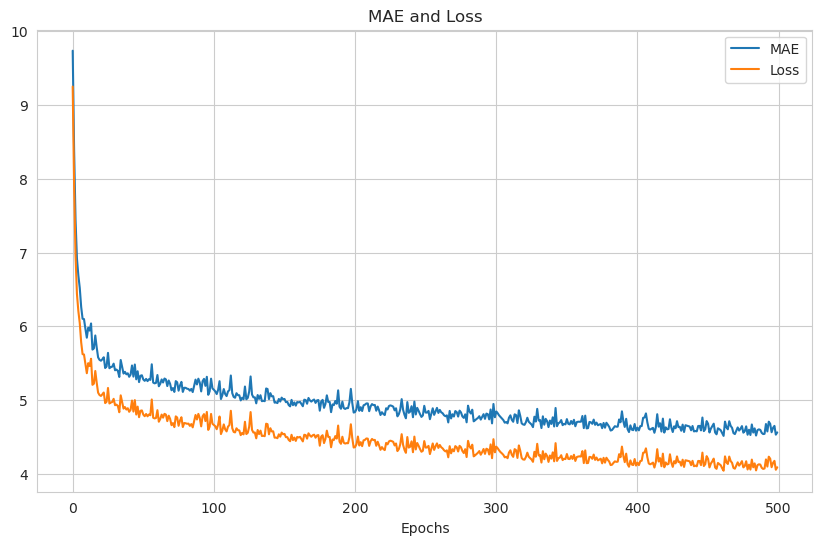

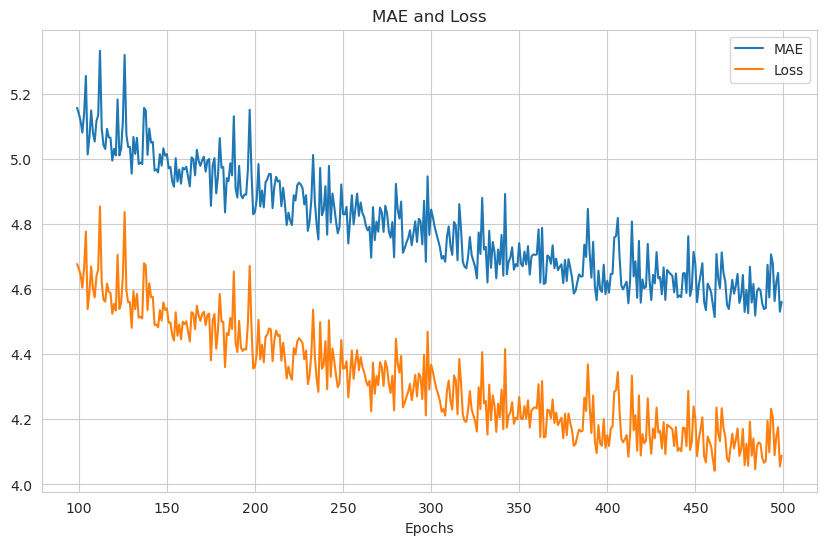

In [15]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), title='MAE and Loss', xlabel='Epochs', legend=['MAE', 'Loss'])

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(x=epochs_zoom, y=(mae_zoom, loss_zoom), title='MAE and Loss', xlabel='Epochs', legend=['MAE', 'Loss'])

## Model Prediction

Once training is done, you can generate the model predictions and plot them against the validation set.


In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


2024-06-14 13:30:01.472435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


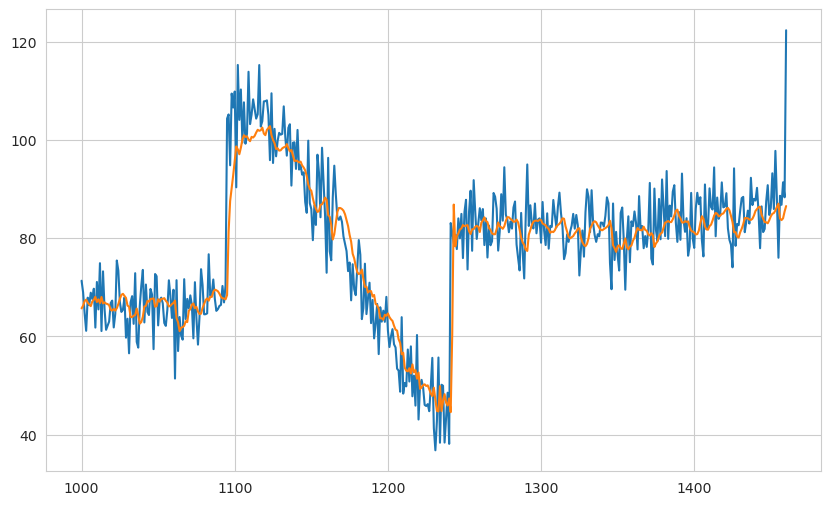

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the metrics as usual.

In [18]:
## Compute the MAE and MSE
print(metrics.mean_squared_error(x_valid, results).numpy())
print(metrics.mean_absolute_error(x_valid, results).numpy())

43.153088
4.852825


## Wrap Up

In this lab, you were able to build and train a CNN-RNN model for forecasting. This concludes the series of notebooks on training with synthetic data. In the next labs, you will be looking at a real world time series dataset, particularly sunspot cycles. See you there!

## Optional - Adding a Callback for Early Stopping

In this optional section, you will add a callback to stop training when a metric is met. You already did this in the first course of this specialization and now would be a good time to review.

First, you need to prepare a validation set that the model can use and monitor. As shown in the previous lab, you can use the `windowed_dataset()` function to prepare this.

In [19]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can reset the weights of the model or just continue from where you left off.

In [20]:
# Uncomment if you want to reset the weights
# model.set_weights(init_weights)

Next, you will define a callback function that is run every end of an epoch. Inside, you will define the condition to stop training. For this lab, you will set it to stop when the `val_mae` is less than `5.2`.

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.2):
        # Stop if threshold is met
        print("\nRequired val MAE is met so cancelling training!")
        self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

Remember to set an appropriate learning rate here. If you're starting from random weights, you may want to use the same rate you used earlier. If you did not reset the weights however, you can use a lower learning rate so the model can learn better. If all goes well, the training will stop before the set 500 epochs are completed.

In [22]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
     50/Unknown 1s 3ms/step - loss: 4.0931 - mae: 4.5647

2024-06-14 13:30:02.856212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:30:02.856239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]



Required val MAE is met so cancelling training!
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0824 - mae: 4.5530 - val_loss: 4.6212 - val_mae: 5.0979


2024-06-14 13:30:03.160363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-14 13:30:03.160393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-14 13:30:03.160454: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10516379324306634655


In practice, you normally have a separate test set to evaluate against unseen data. For this exercise however, the dataset is already very small so let's just use the same validation set just to verify that the results are comparable to the one you got earlier.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


2024-06-14 13:30:03.478468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


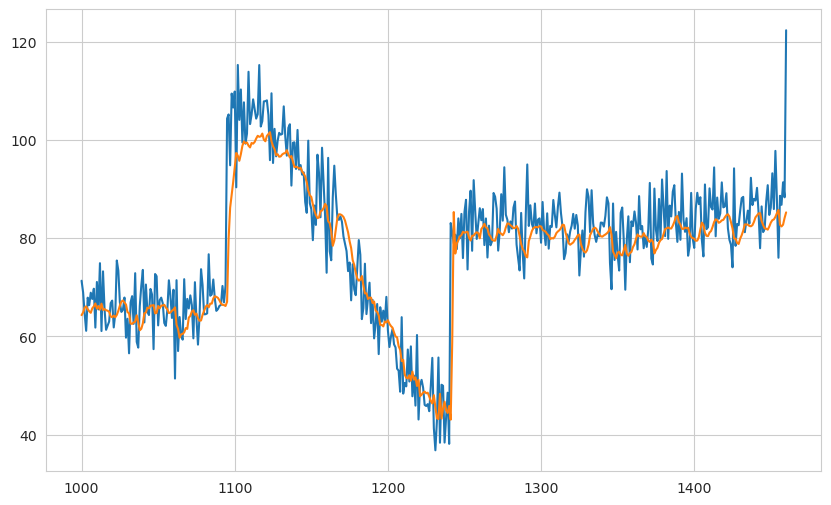

In [23]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

The computed metrics here will be slightly different from the one shown in the training output because it has more points to evaluate. Remember that `x_valid` has 461 points that corresponds to `t=1000` to `t=1460`. `val_set` (which is a windowed dataset from `x_valid`), on the other hand, only has 441 points because it cannot generate predictions for `t=1000` to `t=1019` (i.e. windowing will start there).

In [24]:
## Compute the MAE and MSE
print(metrics.mean_squared_error(x_valid, results).numpy())
print(metrics.mean_absolute_error(x_valid, results).numpy())

47.209175
5.041725
